# Calendar Effect in NASDAQ Stock Market

In this notebook we will discuss the initial analysis for seven different calendar effects:
- Monday effect
- January effect
- Santa Claus Rally effect
- Turn-of-the-Month effect
- Half-Month effect
- Halloween effect (Sell in May and Go Away)
- Holiday effect

## Preporcessing the dataset

When we prepare the data for analysis we calculate the return for every stock value using `.pct_change():` function which calculates the percentage difference between two consecutive values by using the formula:
$${R_{t} = \frac{adjPrice_{t} - adjPrice_{t-1}}{adjPrice_{t-1}}}$$

we also drop all the rows with no return, which are mainly the first row of each stock ticker.
As a part of cleaning the data we drop all the rows that have return less 50% and more than -50%, as we consider them outlier that are goinh to skew our result. In latter analysis we will try to make use of these outliers and to understand why did they happen; however, since in this study we are only making initial analysis and we are using T-test we decided it is best to drop them as the mean would be very sensitive to them

Next, we compute **return volatility** using a **20-trading-day rolling window**, which serves as a proxy for short-term risk. Volatility at time $$ t $$is defined as the standard deviation of returns over the previous 20 trading days:

$$
\sigma_t = \sqrt{\frac{1}{20 - 1} \sum_{i=0}^{19} \left( R_{t-i} - \bar{R}_{t,20} \right)^2}
$$

where:
- The return on day t-1
$$ R_{t-i}$$
- The mean return over the past 20 trading days is given by:
$$

\bar{R}_{t,20}

$$
- To measures the dispersion of recent returns around their mean:

$$
\sigma_t
$$ 

As with returns, the first 19 observations of each stock ticker are dropped since a full 20-day window is required to compute volatility.

In [1]:
from src.data.data import *
df = load_all_stocks()
metadata = load_metadata()
fed = load_fed_funds()
df = add_interest_rate(df, fed)
df = prepare_data_for_analysis(df, metadata)
df = add_santa_claus_rally_flag(df)
df_with_returns = df

Geting the database ready for analysis

In [2]:
df_by_date = df.groupby("Date")['Return'].mean().reset_index()
df_copy = df_by_date[["Date", "Return"]].copy()
df_copy["day"] = df_copy["Date"].dt.dayofweek
df = assign_period_of_month(df)
df = add_general_period_column(df)
df = find_days_before_and_after_holidays(df)
jan_returns = df.loc[df['Month'] == 1, 'Return']
non_jan_returns = df.loc[df['Month'] != 1, 'Return']
santa_returns = df.loc[df['Is_SCR'], 'Return']
non_santa_returns = df.loc[~df['Is_SCR'], 'Return']

In [3]:
from src.scripts.crisis import *
from src.scripts.regression import *
from src.scripts.significance_test import *

## Analysis

### Normality Test

$$
H_0:\ \text{the data are normally distributed}
\qquad
H_1:\ \text{the data are not normally distributed}
$$

Across all calendar effects considered being investigated we got a $P-value = 0.000$. Thus, the normality hypothesis is consistently rejected which aligns with well-established evidence in financial economics: stock returns are not normally distributed.

Rather than being a setback, this result plays an important role in the investigation. It urges the us to **go beyond a single testing framework**. While mean-based tests can still provide useful insights in large samples, they must be complemented with **distribution-free methods** that remain valid even when normality fails.

### Welch's Test

We use the `ttest_ind()` function to verify the significancy of the results, so we divide the set into two different parts:
-   Returns in January
-   Return thorughout the rest of the year

`ttest_ind()` with `equal_var = False` uses the Welch's T-Test which is better for our data because the samples sizes are different (January vs all other months):
$$t = {\frac{\bar{X}_1- \bar{X}_2}{\sqrt{\frac{s_1}{n_1} + \frac{s_2}{n_2}}}}$$

where
- $\bar{X}_1$ and $\bar{X}_2$ are the **sample means**.
- ${s_1}$ and ${s_2}$ are the **sample variances**.
- ${n_1}$ and ${n_2}$ are the **sample sizes**.

We also get the $p-value$ of the test which we can use to detemine the significance of the result:
- $p-value < 0.05$ means significant results
- $p-value > 0.05$ means sunignificant results

### Mann–Whitney U Test

Unlike Welch’s test, Mann–Whitney does not rely on normality distribution assumptions and does not compare averages. Instead, it evaluates whether returns from one calendar period tend to be consistently higher or lower than those from another period across the entire distribution.

$$
H_0:\ \mu_1 = \mu_2
\qquad
H_1:\ \mu_1 \neq \mu_2
$$

When both samples are large (typically $n_1, n_2 \gtrsim 20$), the Mann–Whitney $U$ statistic is approximately normally distributed.

$$
\mu_U = \frac{n_1 n_2}{2}
$$

$$
\sigma_U = \sqrt{\frac{n_1 n_2 (n_1 + n_2 + 1)}{12}}
$$

$$
Z = \frac{U - \mu_U}{\sigma_U}
$$

### Probability of Superiority

We use the probability of distributy t check the effect size

The probability that previous witnesses ranked a randomly chosen sample from the calendar window higher than another randomly chosen one from the rest of the data
$$
\text{PS} = \frac{U}{n_1 n_2}
$$

### Linear Regression

 To further assess the presence of calendar effects, linear regression models
    are employed to quantify the relationship between calendar indicators and
    asset returns. This approach allows us to control for confounding factors and
    evaluate whether calendar-related variables retain explanatory power once
    standard market dynamics are taken into account.

These are the equations they are tryping to achieve using the linear regression:

Clustering

$$
\text{Return}_t
=
\beta_0
+
\beta_1 \,\mathbb{1}_{\text{Calendar Effect}_t}
+
\beta_2 \,\text{Volatility}_t
+
\beta_3 \,\text{Volume}_t
+
\varepsilon_t
$$

and

Time Series
$$
\text{Return}_t
=
\beta_0
+
\beta_1 \,\mathbb{1}_{\text{Calendar Effect}_t}
+
\beta_2 \,\text{Interest Rate}_t
+
\varepsilon_t
$$


Now we will examin all of these in each effect

## Monday Effect

In [1]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

We wanted to know if the day of the week had an effect on the stock market. So, first of all, we wanted to know if there was a significant difference in transaction volume depending on the day of the week. So, we calculated the average transaction volume for each day of the week for each decade, from the oldest tick in the dataset, 1962, to the most recent, 2020. After this, we computed the average daily volume across all years.

In [2]:
from src.scripts.day_of_the_week import *
df_with_returns, df_by_date=load_data_monday()

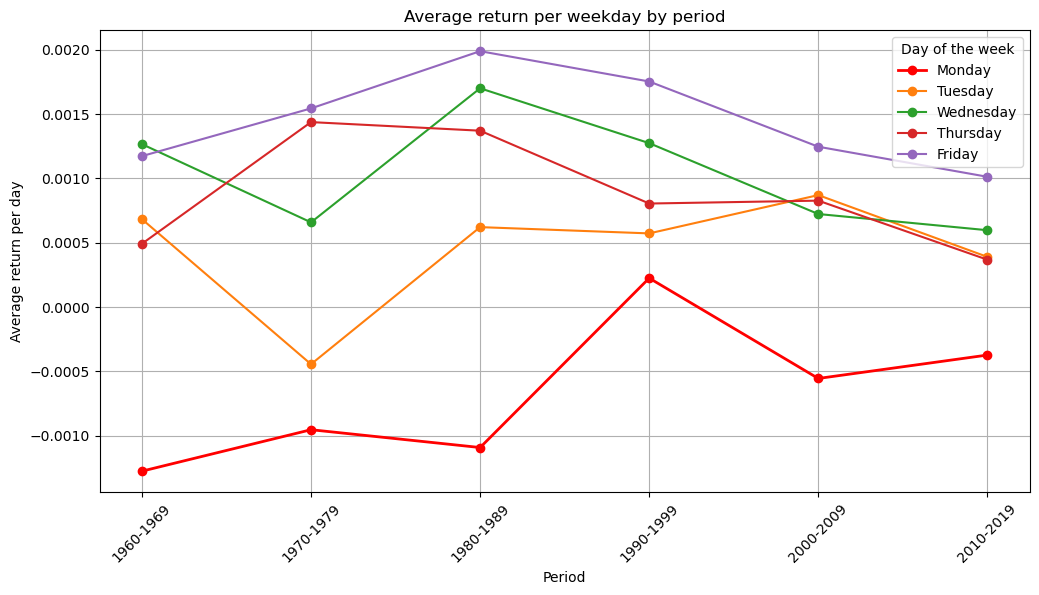

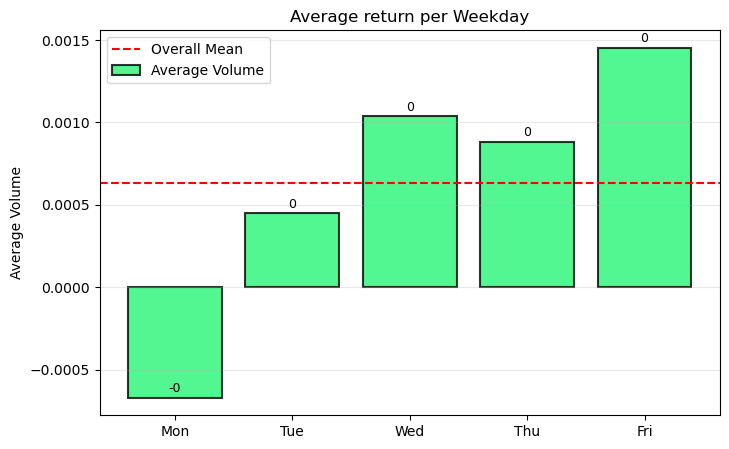

In [3]:
from src.scripts.day_of_the_week import plot_return_per_day
df_last_ten = df_with_returns.copy()
plot_return_per_day(df_last_ten, first_year=1960, last_year=2020)

As the popular belief suggests, Mondays tend to have lower returns compared to other days all the time. We will see if this difference has been statistically significant or not.
To check if it's not  acoincidence, the first step is to determine whether returns follow the same distribution depending on the day of the week. To compare the return distibutions of the weekdays, we will use Welch's test.

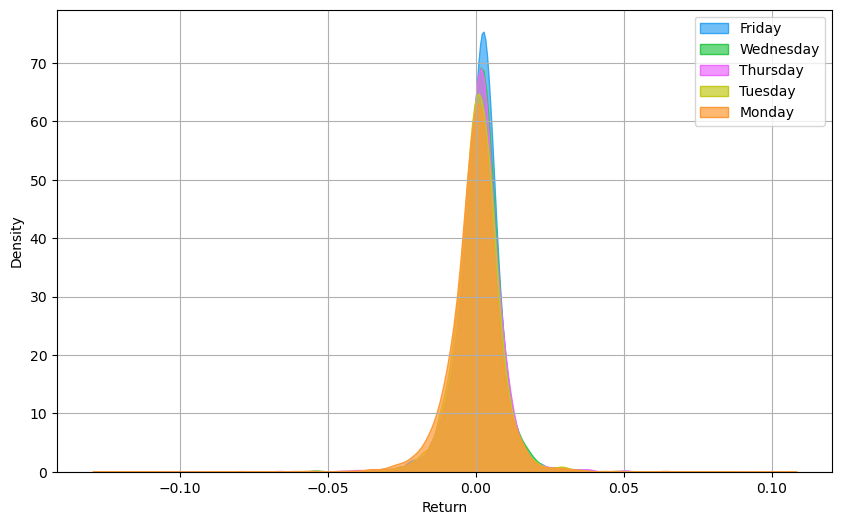

In [4]:
plot_kde_per_day(df_with_returns)

In [7]:
def stat_mw_test(df):
    pvalues = np.zeros((5,5))
    df_test = df.copy()

    for i in range(5):
        for j in range(5):
            filtered_dfnz = df_test[df_test['day'] == i]
            filtered_df = df_test[df_test['day'] == j]
            #test = stats.kstest(filtered_dfnz["Return"],filtered_df["Return"], N=max(len(filtered_dfnz["Return"]) , len(filtered_df["Return"])))
            test = stats.mannwhitneyu(filtered_dfnz["Return"],filtered_df["Return"])

            pvalues[i][j]= test.pvalue
    log_pvalues = np.log(pvalues)

    return pvalues, log_pvalues

def stat_t_test(df):
    df_test=df.copy()
    pvalues = np.zeros((5,5))


    for i in range(5):
        for j in range(5):
            filtered_dfnz = df_test[df_test['day'] == i]
            filtered_df = df_test[df_test['day'] == j]
            #test = stats.kstest(filtered_dfnz["Return"],filtered_df["Return"], N=max(len(filtered_dfnz["Return"]) , len(filtered_df["Return"])))
            test = stats.ttest_ind(filtered_dfnz["Return"],filtered_df["Return"])

            pvalues[i][j]= test.pvalue
    log_pvalues = np.log(pvalues)

    return pvalues, log_pvalues

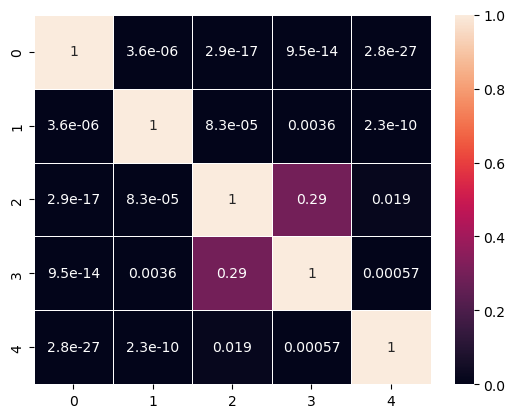

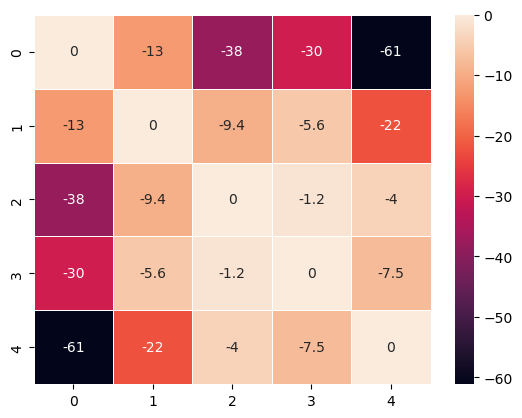

In [5]:
df_copy = df_by_date.copy()
df_copy['day'] = df_copy['Date'].dt.dayofweek
pvalues,log_pvalues = stat_mw_test(df_copy)
sns.heatmap(pvalues, annot=True, linewidth=.5)
plt.show()
sns.heatmap(log_pvalues, annot=True, linewidth=.5)
plt.show()

We can see that all days follow distinct distributions according to the Mann–Whitney U test, except for Wednesday and Thursday, for which no significant difference can be observed. We will now use the Welch test to compare the averages across the days.

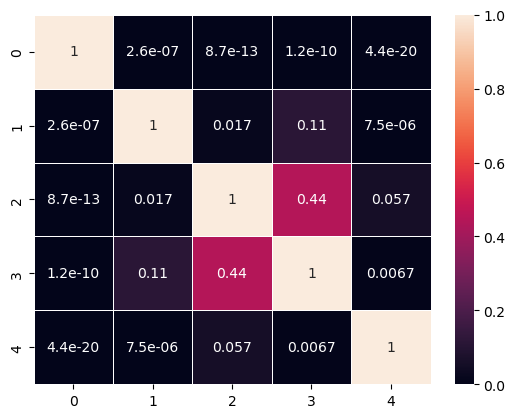

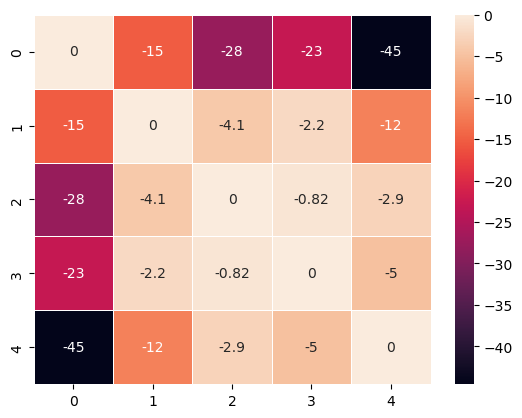

In [6]:
pvalues, log_pvalues = stat_t_test(df_copy)
sns.heatmap(pvalues, annot=True, linewidth=.5)
plt.show()
sns.heatmap(log_pvalues, annot=True, linewidth=.5)
plt.show()

As expected, Wednesday and Thursday do not have a statistically significant difference in their averages. Other pairs of days, such as Thursday and Tuesday or Wednesday and Friday, also show no significant difference. However, Monday stands out with a statistically significant difference in its average. Therefore, we can conclude that, except for Wednesday and Thursday, each day of the week on the Nasdaq tends to follow a distinct distribution, with Monday's average return being significantly lower than that of the other days.

#### Monday effect across time

Since the stock market evolves significantly over time, we will also analyze how the impact of the day of the week changes over different periods. To do so, we will do the Welch test for each decade to see if the difference has always been statistically significant. 

In [8]:
plot_fluvial(df_copy.copy())

Date      1962-01-03 00:00:00
Return               -0.12351
day                         0
Year                     1962
dtype: object
Date      2020-04-01 00:00:00
Return               0.102244
day                         4
Year                     2020
dtype: object


It is normal for these patterns to evolve over time, as market participants tend to exploit any anomalies they detect. Interestingly, however, Mondays showed for a long time and continues to show distinct behavior compared to other days. As we see on the first plot, it has consistently been lower and we see here that it has most of the time been significant.

## January Effect

The January effect is one of the most popular calendar effects in stock market, particularly in small or mid capital companies, where the prices tend to rise in January more than in other months.
Here we check the exsistance of the january effect across different decads and across different exchange lisitng as well and how significant is the results.

In [14]:
from src.scripts.januarry_effect import *

/var/folders/57/pp_xfrgn76315b5mj53m6d0h0000gn/T/ipykernel_49446/4161522683.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


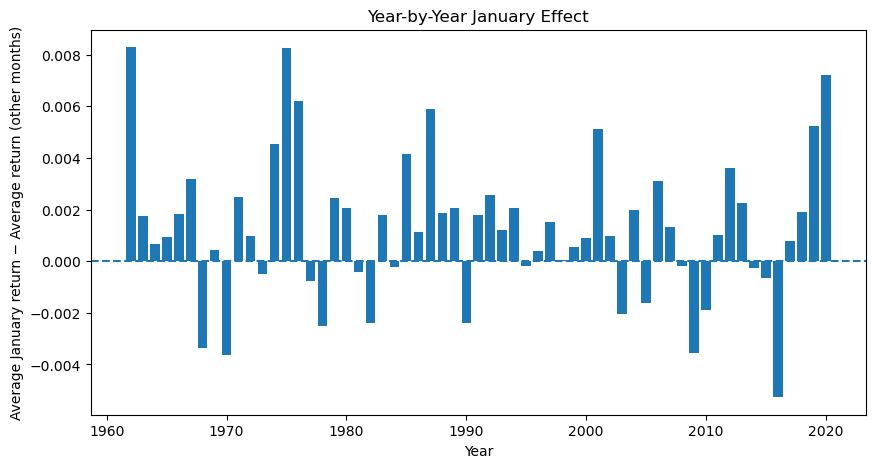

In [5]:
january_year_by_year(df)

In [15]:
check_normalitiy(jan_returns, "January Returns")
check_normalitiy(non_jan_returns, "Other Months Returns")

[January Returns] Stat: 857769.4206
[January Returns] P-value: 0.0000
[Other Months Returns] Stat: 7575777.4247
[Other Months Returns] P-value: 0.0000


Both January and non-January returns strongly reject normality, reflecting the heavy-tailed and skewed nature of financial markets. This confirms that calendar effects cannot be evaluated under idealized Gaussian assumptions and motivates the use of robust and non-parametric statistical tests.
However we apply the Central Limit Theorem and assume normal distribution as the number of samples is bigger than 20

In [16]:
calculate_welch_t_test(jan_returns, non_jan_returns, "January Effect")

[January Effect] T-test: 29.7588, P-value: 0.0000


January returns are significantly higher than returns in other months. The result is consistent with your descriptive plots, where January’s average return sits above other months.

In [17]:
calculate_mannwhitneyu(jan_returns, non_jan_returns, "January Effect")

[January Effect] mannwhitneyu-test: 22095602484142.5000, P-value: 0.0000


The Mann–Whitney U test strongly rejects the null hypothesis (p < 0.001), indicating that January stock returns follow a statistically different distribution from returns in the rest of the year, providing non-parametric evidence in favor of the January Effect.

In [18]:
from src.scripts.regression import run_ols

### Linear Regression

In [19]:
m1 = run_ols(df, effect_col="is_january", controls=["fed_funds"], mode="ts", hac_lags=6)
m2 = run_ols(df, effect_col="is_january", controls=["volatility","Volume"], mode="cluster", hac_lags=6)

In [20]:
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.562
Date:                Sun, 21 Dec 2025   Prob (F-statistic):            0.00142
Time:                        23:01:56   Log-Likelihood:                 48895.
No. Observations:               14643   AIC:                        -9.778e+04
Df Residuals:                   14640   BIC:                        -9.776e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006   8.64e-05      6.406      0.0

 The January effect becomes statistically significant once interest rates are controlled for and serial correlation is addressed using HAC standard errors which means that it managed to survive the serial correlation correction. On the other had, fed funds have a negative coffiecient and a p-value > 0.5 which makes it insignificant.That being said, the model still explains only a very small fraction of daily return variation it only suggets that January have a very faint yet persistent footprint in the data.

In [21]:
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.292
Date:                Sun, 21 Dec 2025   Prob (F-statistic):             0.0761
Time:                        23:02:02   Log-Likelihood:             4.7134e+07
No. Observations:            24017456   AIC:                        -9.427e+07
Df Residuals:                24017452   BIC:                        -9.427e+07
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      3.219      0.0

 While the estimated coefficient suggests that returns in January are one average slightly higher, the p-value is below 0.5 which makes it significance fragile. The effect is just outside the thresholds, hinting that there might have been a possible pattern but it fails to make a decisive conclusion. Once volatility and trading volume are taken into account, neither variable shows a statistically meaningful relationship with returns. This suggest that while the January effect may leave a faint trace in the data, it is far from being reliable. 

### Across decades

We wanted to check if there was indeed a January effect in our data, and we wanted to see whether it is persistent across different decades or not. According to recent studies, the the January effect shouldn't be as visible in the current decade due to the emergence of algorithm based trading.
So we make a comparison from the 1960s to the 2010s cause our data ends in April 2020. However, we still compute the january effect in 2020 but we treate it as a special case.

In [22]:
jan_effect_decade_results = calculate_january_effect_by_decade(df_with_returns)


JANUARY EFFECT BY DECADE
Decade        Jan Mean  Other Mean   Difference   Win Rate   T-Stat   P-Value
--------------------------------------------------------------------------------
1960s          0.136%     0.043%     0.093%        87.5%      3.55    0.0004
1970s          0.299%     0.028%     0.270%        60.0%     15.28    0.0000
1980s          0.259%     0.080%     0.179%        70.0%     22.15    0.0000
1990s          0.163%     0.087%     0.077%        80.0%     11.35    0.0000
2000s          0.105%     0.060%     0.045%        60.0%      7.85    0.0000
2010s          0.118%     0.034%     0.083%        60.0%     23.55    0.0000
2020s         -0.103%    -0.826%     0.723%       100.0%     41.98    0.0000

Win Rate = % of years where January returns are greater than other months in that decade


This table represents the percentage mean of January returns compared to the returns of other months. From the calculated T-test and P-value we can assume that there is indeed a January effect. It was the highest in 1970s and the lowest in 2000s, we assume it is because the dot com bubble burst (2000-2002) and the financial crisis (2008-2009); however further analysis needs to be done on this part to adress the outliers.
<!-- we can see that having a 1000USD in stocks, in January you will gain 293USD , it is not a huge one -->

We can also see see that the win rate where January returns exceed the other month returns are higher than 50%. This shows that eventhough January is in not always exceeding the other months, there are still very high chances that it will happen.

In the 2020s, we can see that we have a 100% win rate, that is because in this case we are only analysing the first 4 months in 2020. We also have to keep in mind that January is considered pre-COVID; however January, March, and April are during the peak of the pandamic so the market was unstable at that period it also justify why the returns of that year are all negative

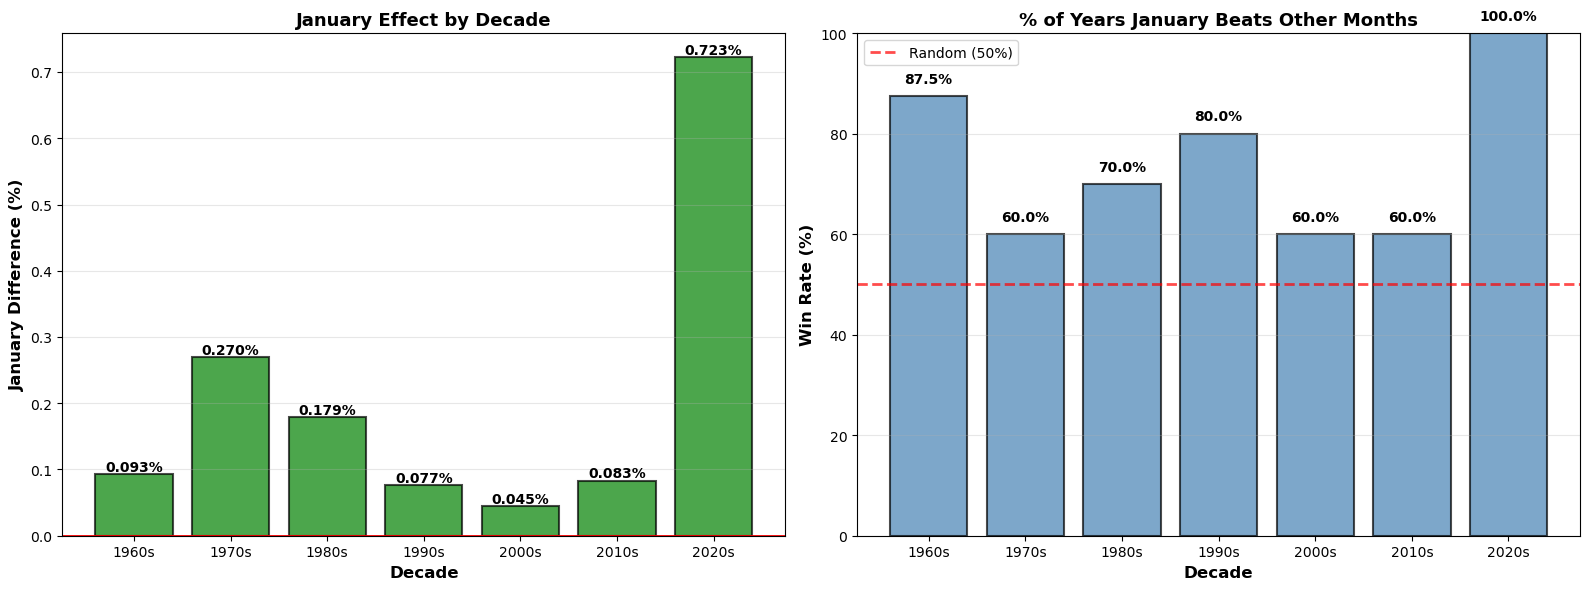

In [23]:
graph_january_effect_by_decade(jan_effect_decade_results)

Here we have a graph for visualizing the table we discussed above.
In the first graph we basically can see the curve declining as the Januarry effect deacreses as the time passes which confirms the hypothesis that the emergence of algorithm based trading caused the seasonaly anomoulies like January effect to decrease.
The reason why graph started to go up again in 2010s needs further analysis; however, as we discussed before the 2020s bar is a special case since it is just a 4-months analysis and not a decade like te rest.


### Across different exchanges

According to previous studies we found that January effect should be more visisble in small or mid capital companies, so we wanted to check if our data have the same reasults.

In [24]:
jan_effect_exchange_results = january_effect_significance_by_exchange(df_with_returns)


STATISTICAL SIGNIFICANCE TEST - JANUARY EFFECT BY EXCHANGE
Exchange                    Jan Mean   Other Mean       Diff     T-Stat    P-Value
------------------------------------------------------------------------------------------
NYSE American (Small)         0.249%     0.022%       0.227%     14.906     0.0000
NYSE (Large)                  0.086%     0.049%       0.036%     13.519     0.0000
NYSE Arca                     0.013%    -0.014%       0.027%      1.261     0.2075
NASDAQ Global (Large)         0.147%     0.040%       0.107%     22.876     0.0000
BATS                         -0.050%     0.004%      -0.054%     -1.640     0.1011


From this table we can see that the results are not significant in the Arca and BATS stock exchange which makes sense because Arca mainly focuses on the etfs which are not analyzed here. On the other hand, BATS (Better Alternative Trading Systems) is a semi-profitable utility that was introduced to make the NASDAQ index more nuetral. It also have 17 companies only, which makes it very small compared to the other exchanges.

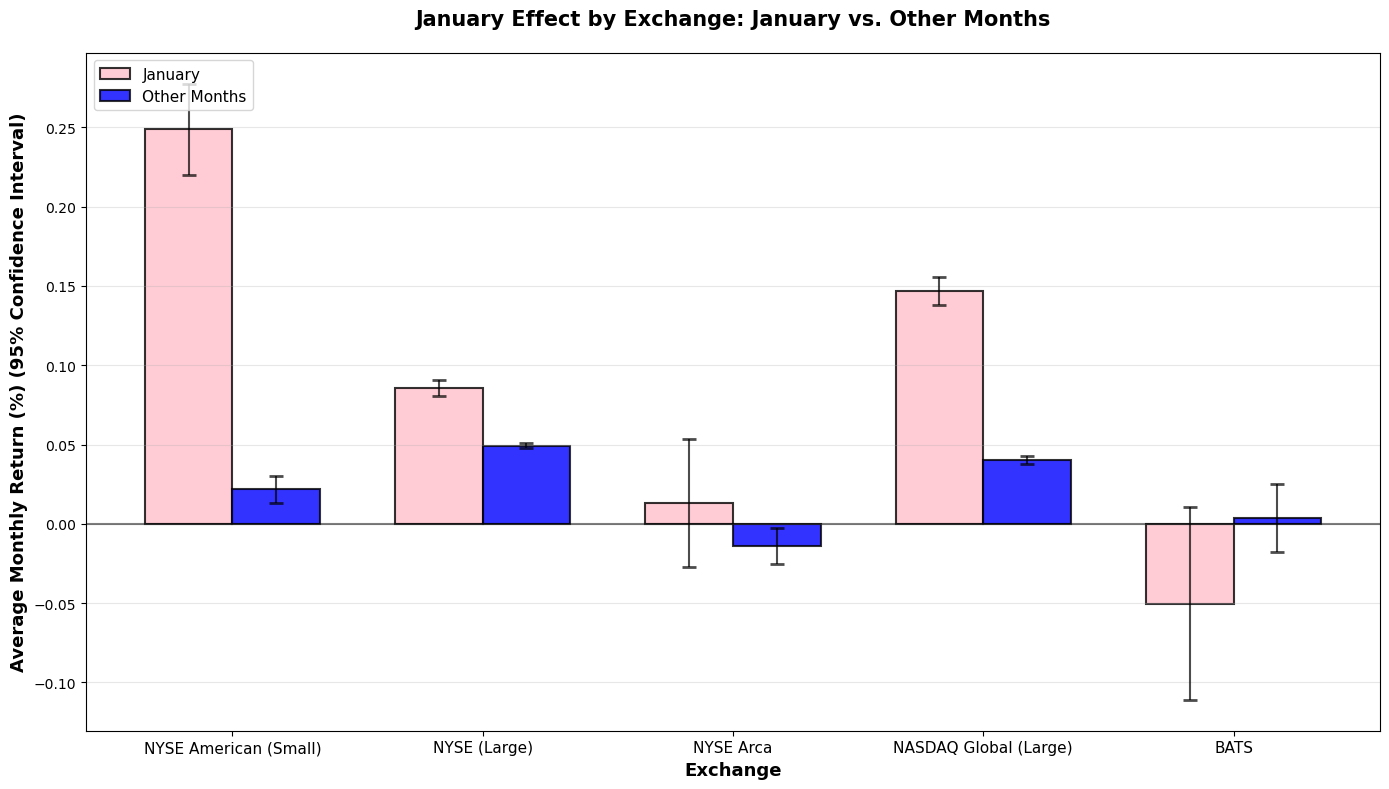

In [25]:
graph_january_effect_by_exchange(jan_effect_exchange_results)

This graph also confirms the hypothesis that for small and mid-capital companies we have the most January effect compared to others; however we can still see that it is significant in global and large companies as well.

### Dot Com Bubble 

In [26]:
january_df = add_dotcom_period(df)

In [27]:
jan_pre = january_df[january_df["dotcom_period"] == "pre_bubble"]["Return"]
jan_bubble = january_df[january_df["dotcom_period"] == "bubble"]["Return"]
jan_post = january_df[january_df["dotcom_period"] == "post_bubble"]["Return"]

In [28]:
print(len(jan_pre), len(jan_bubble), len(jan_post))

5767375 1709565 16540516


In [29]:
calculate_welch_t_test(jan_pre, jan_bubble, effect_name="January: Pre-bubble vs Bubble")
calculate_welch_t_test(jan_bubble, jan_post, effect_name="January: Bubble vs Post-bubble")
calculate_welch_t_test(jan_pre, jan_post, effect_name="January: Pre-bubble vs Post-bubble")

[January: Pre-bubble vs Bubble] T-test: 12.1571, P-value: 0.0000
[January: Bubble vs Post-bubble] T-test: 3.1914, P-value: 0.0014
[January: Pre-bubble vs Post-bubble] T-test: 34.7706, P-value: 0.0000


January returns before the dot com bubble are statistically very different from those during the bubble. January returns did not change immediately after the bubble post bubble as it is still differ significantly from bubble years.
However from last test we can conclude that: The January effect observed before the 1990s no longer characterizes modern markets.

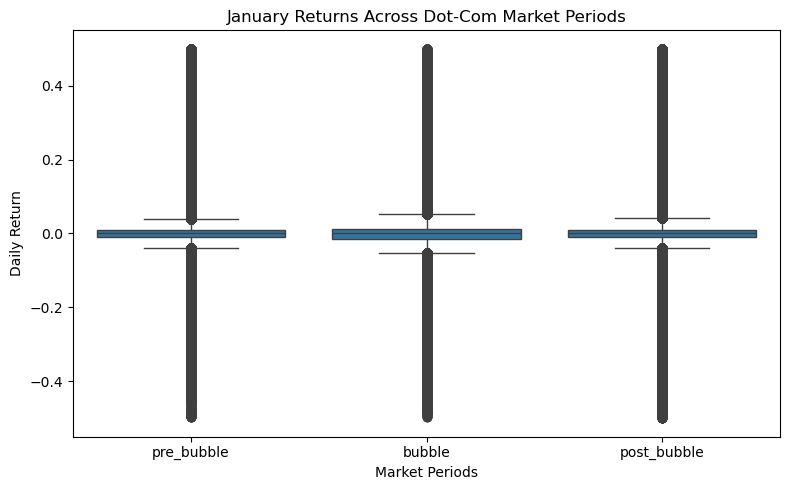

In [30]:
plot_january_dotcom(january_df)

Despite similar dispersion and extreme events across regimes, the location of the distribution changes a little, this suggests a structural shift in January returns around the dot com period. (mostly between the before vs after periods)

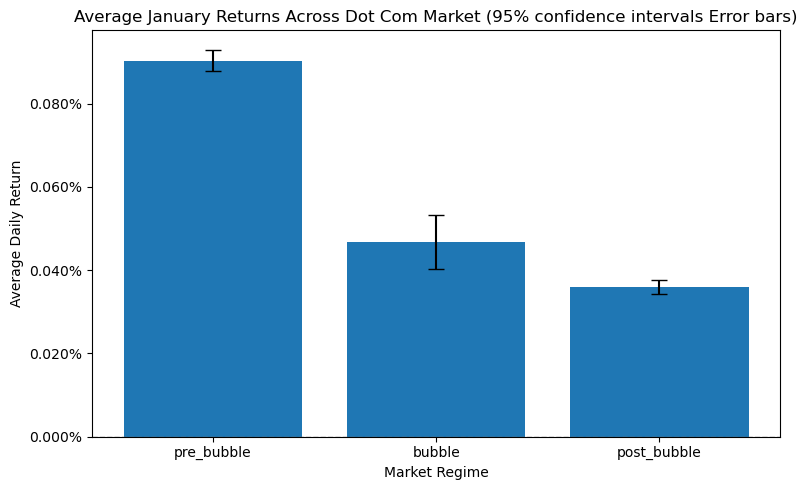

In [31]:
plot_jan_dotcom_average(january_df)

The January Effect was strongest and most reliable before the Dot Com bubble, weakened during the bubble, and never fully recovered afterward suggesting that market structure and investor behavior fundamentally altered this seasonal anomaly.

### Financial Crisis

In [32]:
df = add_global_financial_crisis_period(df)
df["month"] = df["Date"].dt.month
january_df = df[df["month"] == 1]

In [33]:
jan_pre = january_df[january_df["financial_crisis"] == "pre_crisis"]["Return"]
jan_crisis = january_df[january_df["financial_crisis"] == "crisis"]["Return"]
jan_post = january_df[january_df["financial_crisis"] == "post_crisis"]["Return"]

In [34]:
print(len(jan_pre), len(jan_crisis), len(jan_post))

868062 133316 988235


In [35]:
calculate_welch_t_test(jan_pre, jan_crisis, effect_name="January: pre Crisis vs during Crisis")
calculate_welch_t_test(jan_crisis, jan_post, effect_name="January: during Crisis vs post crisis")
calculate_welch_t_test(jan_pre, jan_post, effect_name="January: pre Crisis vs post crisis")

[January: pre Crisis vs during Crisis] T-test: 23.7291, P-value: 0.0000
[January: during Crisis vs post crisis] T-test: -16.6437, P-value: 0.0000
[January: pre Crisis vs post crisis] T-test: 20.7121, P-value: 0.0000


The Global Financial Crisis represents a clear break in January’s historical behavior. January performance improves after the crisis, but this improvement is statistically distinct from crisis behavior. However even after recovery, January returns remain significantly different from the period before the crisis.

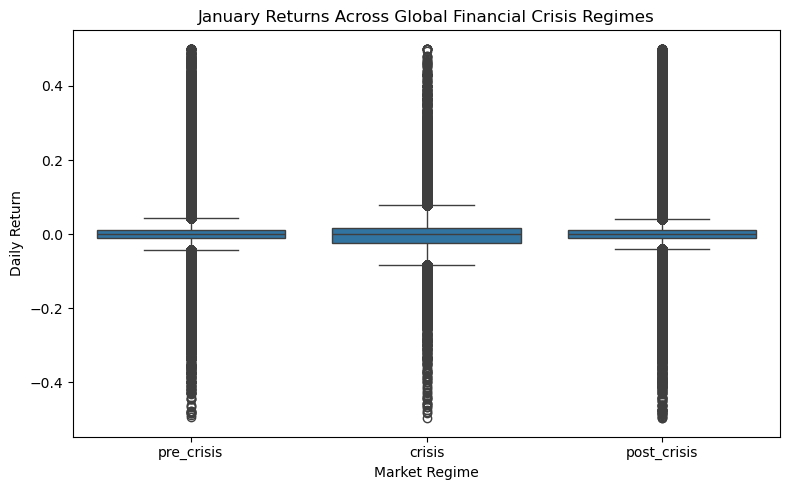

In [36]:
plot_jan_crisis(january_df)

January return distributions exhibit heavy tails across all periods, but the crisis period specifically is marked by a downward shift in the median, indicating a worse January performance during the Crisis it self.

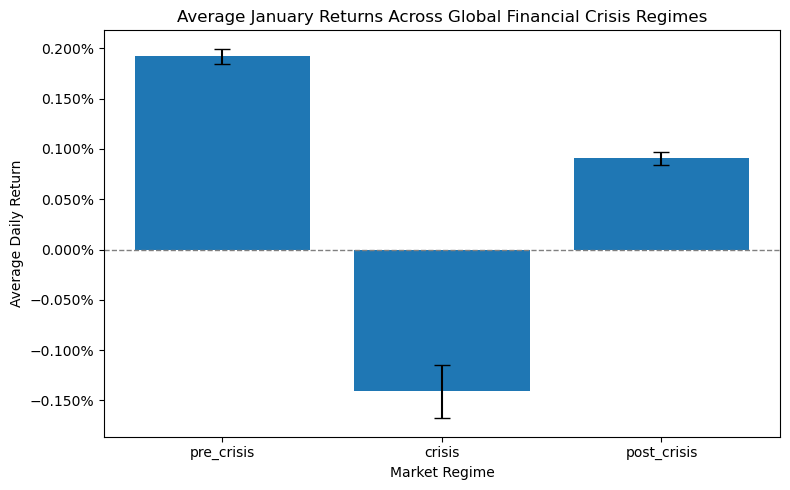

In [37]:
plot_jan_crisis_average(january_df)

Average January returns turn sharply negative during the Global Financial Crisis and only partially recover afterward, suggesting a lasting disruption to the January effect

## Santa Clause Rally Effect

The Santa Claus Rally effect is mainly the tendency for stock markets to rise in the last five trading days of December and the first two trading days of the new year. There are several theories as to why this effect happends some of them are: holiday optimism and end-of-year bonuses.

While analyzing the Santa Claus Rally we used the same methods used in January effect; like cleaning the data from the outliers and using the Welch's T-Test

In [38]:
from src.scripts.santa_claus_rally import *

In [39]:
check_normalitiy(santa_returns, "Santa Claus Rally Returns")
check_normalitiy(non_santa_returns, "The rest of the year Returns")

[Santa Claus Rally Returns] Stat: 342070.3508
[Santa Claus Rally Returns] P-value: 0.0000
[The rest of the year Returns] Stat: 8081797.9221
[The rest of the year Returns] P-value: 0.0000


Normality tests again strongly reject the hypothesis that either Santa Claus Rally returns or returns during the rest of the year follow a normal distribution. This result is consistent with well-known properties of financial returns, which exhibit skewness, fat tails, and volatility clustering. We therefore complement Welch’s t-tests with the non-parametric Mann–Whitney U test, ensuring that our conclusions about the Santa Claus Rally are robust to distributional deviations.

In [40]:
calculate_welch_t_test(santa_returns, non_santa_returns, "Santa Claus Rally Effect")
analyze_santa_claus_rally(df)

[Santa Claus Rally Effect] T-test: 62.5301, P-value: 0.0000

SANTA CLAUS RALLY (SCR) SIGNIFICANCE TEST
  Avg. Daily Return (SCR Period):     0.3128%
  Avg. Daily Return (Other Days):     0.0421%
  Difference (Difference):            0.2707%
--------------------------------------------------
  T-Statistic:                        62.530
  P-Value:                            0.00000


Here we can see that the Santa Claus Rally exits in our data and that the difference between it and the other trading days are actually significant compared to the rest of the trading days throughout the week.

In [41]:
calculate_mannwhitneyu(santa_returns, non_santa_returns, "Santa Claus Rally Effect")


[Santa Claus Rally Effect] mannwhitneyu-test: 8282136107953.0000, P-value: 0.0000


The Mann Whitney U test strongly rejects the null hypothesis (p < 0.001), indicating that returns during the Santa Claus Rally period follow a statistically different distribution from returns during the rest of the year, providing robust non-parametric evidence for the Santa Claus Rally effect.

Linear Regression

In [42]:
m3 = run_ols(df, effect_col="Is_SCR", controls=["fed_funds"], mode="ts", hac_lags=6)
m4 = run_ols(df, effect_col="Is_SCR", controls=["volatility","Volume"], mode="cluster", hac_lags=6)

In [43]:
print(m3.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     21.86
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           3.32e-10
Time:                        23:07:07   Log-Likelihood:                 48909.
No. Observations:               14643   AIC:                        -9.781e+04
Df Residuals:                   14640   BIC:                        -9.779e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006   8.42e-05      6.655      0.0

 Santa Claus Rally has higher average returns by around 0.25%, it survives the correction for the serial correlation. That also means that it can't be explained by interest rates as they have a very small and negative coffiecient value with a p-value that is passes the significance threshhold. Now the detectived can assume that from a time series prespective, tha Santa claus Rally leave a significant footprint.

In [44]:
print(m4.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.852
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           3.16e-05
Time:                        23:07:13   Log-Likelihood:             4.7136e+07
No. Observations:            24017456   AIC:                        -9.427e+07
Df Residuals:                24017452   BIC:                        -9.427e+07
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      3.230      0.0

The coefficient is positive, and it has a significant p-value. Santa clause rally survives controlling the volume and volatility which both has a very high p-value so the detictives can assume that they doesn't justify the santa claus battern in the stocks. This makes this anomaly more genuine rather than being a noise.

### Across decades

In [45]:
scr_decade_results = analyze_santa_claus_rally_by_decade(df)


SANTA CLAUS RALLY (SCR) SIGNIFICANCE TEST BY DECADE
Decade       SCR Mean Other Mean Difference     T-Stat    P-Value
---------------------------------------------------------------------------
1960s          0.141%     0.047%     0.094%     2.214    0.0270
1970s          0.585%     0.034%     0.551%    17.670    0.0000
1980s          0.374%     0.086%     0.288%    21.502    0.0000
1990s          0.430%     0.083%     0.347%    29.197    0.0000
2000s          0.356%     0.055%     0.301%    32.225    0.0000
2010s          0.238%     0.035%     0.203%    35.152    0.0000
2020s          0.099%    -0.608%     0.707%    21.914    0.0000


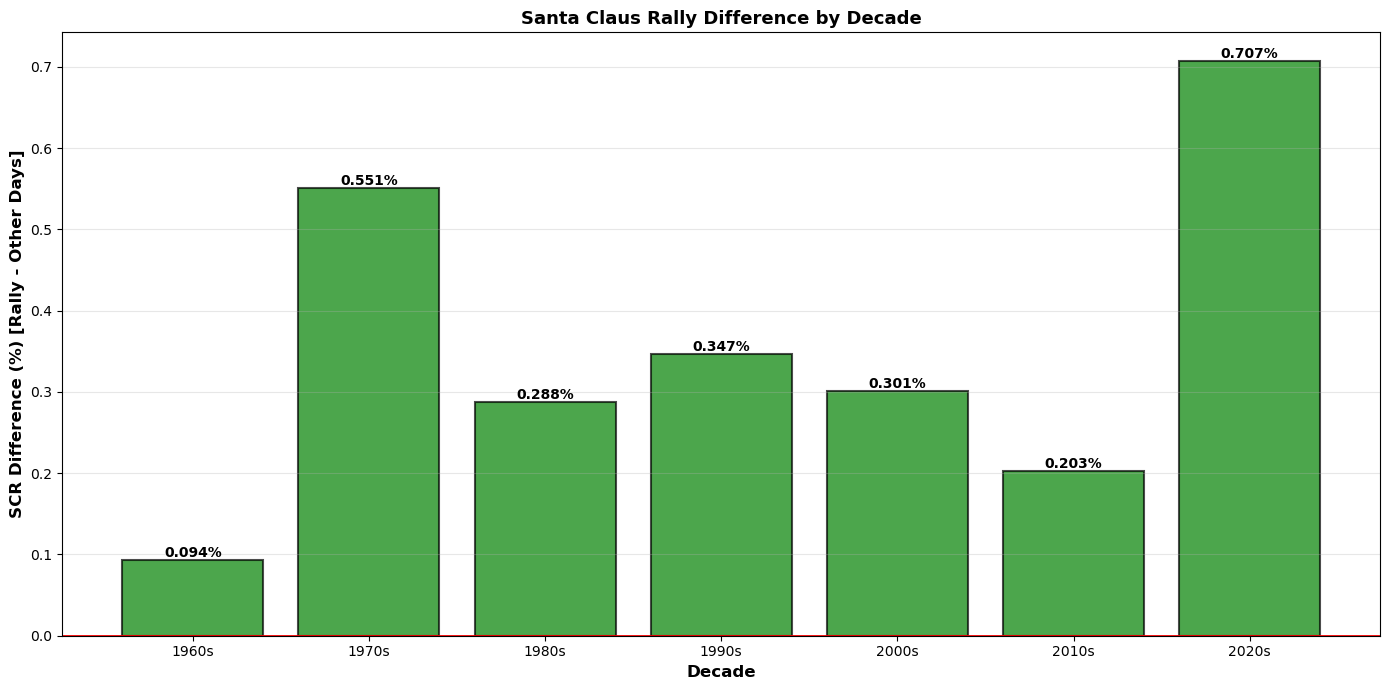

In [46]:
graph_scr_by_decade(scr_decade_results)

Here we can see that the santa claus rally has had a strong presence in the market since the 1970s. There is a potential decline happening starting from the 1990s; however it is still significant compared to other trading days of the week.

Here as well 2020s in a specal case since it is only 4 months, an most likely it had the highest difference because of COVID related volatility and market unstability.

### Across Exchanges

In [47]:
scr_exchange_results = analyze_santa_claus_rally_by_exchange(df)


SANTA CLAUS RALLY (SCR) SIGNIFICANCE TEST BY EXCHANGE
Exchange                    SCR Mean Other Mean    Premium     T-Stat    P-Value
------------------------------------------------------------------------------------------
NYSE American (Small)         0.512%     0.027%     0.485%    18.214    0.0000
NYSE (Large)                  0.275%     0.046%     0.230%    52.383    0.0000
NYSE Arca                     0.159%    -0.017%     0.176%     4.554    0.0000
NASDAQ Global (Large)         0.337%     0.041%     0.297%    37.166    0.0000
BATS                          0.022%    -0.002%     0.024%     0.278    0.7814


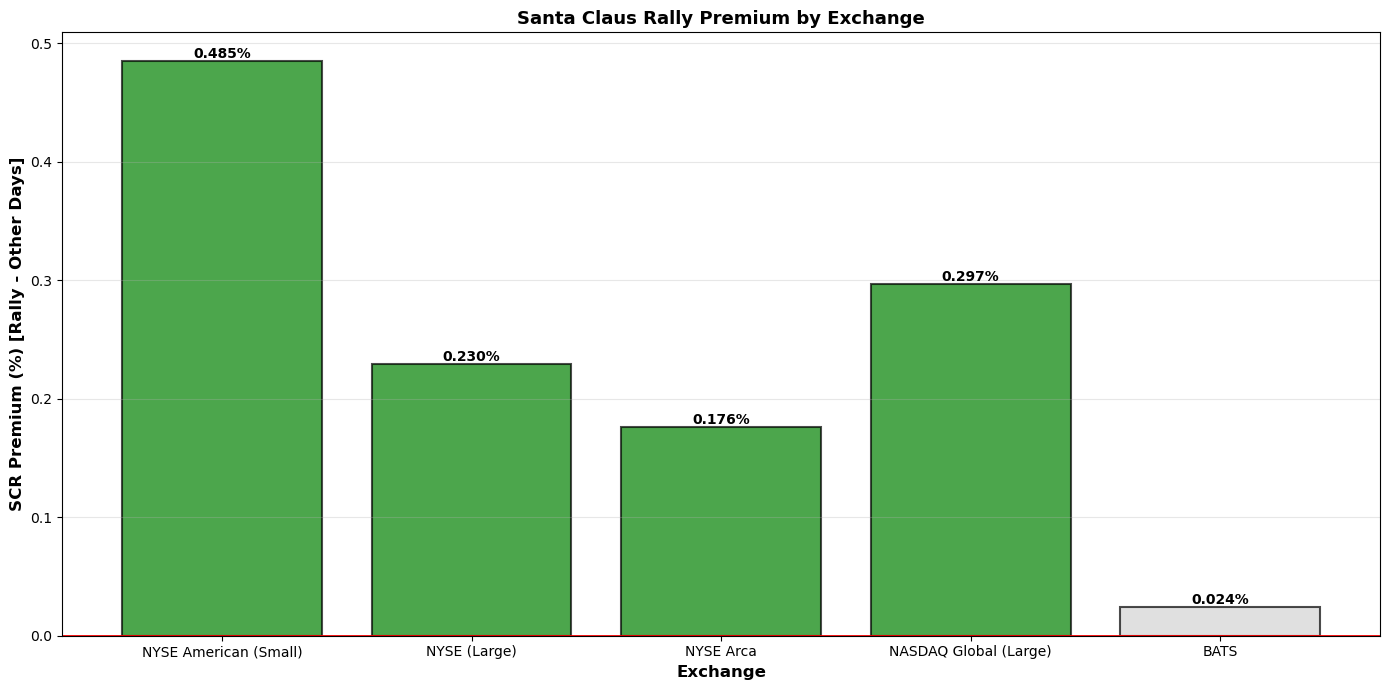

In [48]:
graph_scr_by_exchange(scr_exchange_results)

Here again like the January effect we can see that the santa claus rally is mostly significant in smal and mid cap companies compared to the others. This strongly aligns with the historical expectation that market anomalies tend to be strongest in less efficient, smaller-capitalization stocks. The effect that appears in the NYSE Arca here is likely drived by negative returns throughout the year but this part still needs more analysis as well.

At this point, we were just interested to see if there was indeed a Santa Claus Rally effect in at least some of the exchanges.

### Dot Com Period

In [49]:
df = add_dotcom_period(df)
df["Date"] = pd.to_datetime(df["Date"])
scr_df = df[df["Is_SCR"] == 1]

scr_pre = scr_df[scr_df["dotcom_period"] == "pre_bubble"]["Return"]
scr_bubble = scr_df[scr_df["dotcom_period"] == "bubble"]["Return"]
scr_post = scr_df[scr_df["dotcom_period"] == "post_bubble"]["Return"]

In [50]:
print(len(scr_pre), len(scr_bubble), len(scr_post))

163165 48522 469614


In [51]:
calculate_welch_t_test(scr_pre, scr_bubble, effect_name="Santa Claus Rally: Pre-bubble vs Bubble")
calculate_welch_t_test(scr_bubble, scr_post, effect_name="Santa Claus Rally: Bubble vs Post-bubble")
calculate_welch_t_test(scr_pre, scr_post, effect_name="Santa Claus Rally: Pre-bubble vs Post-bubble")

[Santa Claus Rally: Pre-bubble vs Bubble] T-test: 0.5999, P-value: 0.5486
[Santa Claus Rally: Bubble vs Post-bubble] T-test: 6.2075, P-value: 0.0000
[Santa Claus Rally: Pre-bubble vs Post-bubble] T-test: 15.5888, P-value: 0.0000


The bubble itself did not materially change the strength of the Santa Claus Rally. If the rally existed before, it seems to have continued in a similar way during the bubble. However it behaves very differently in the post-bubble period compared to during the bubble. This suggests a structural break rather than random fluctuation.

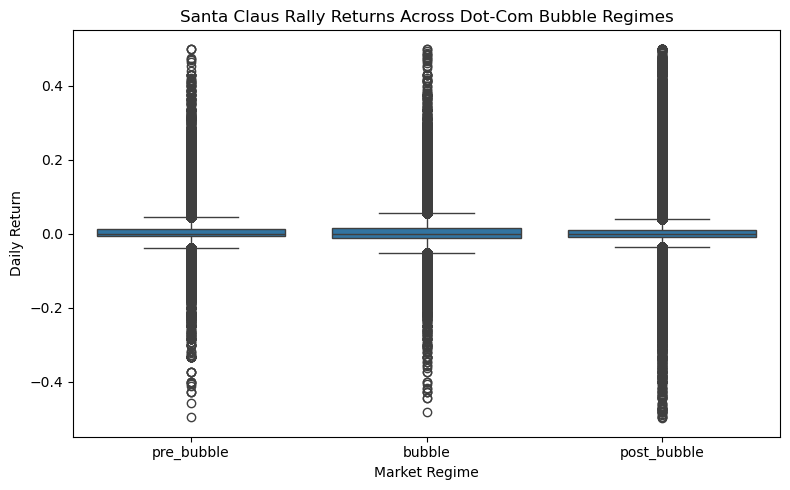

In [60]:
plot_scr_bubble(scr_df)

There is no visible regime break during the bubble, but there is a regime change afterward.

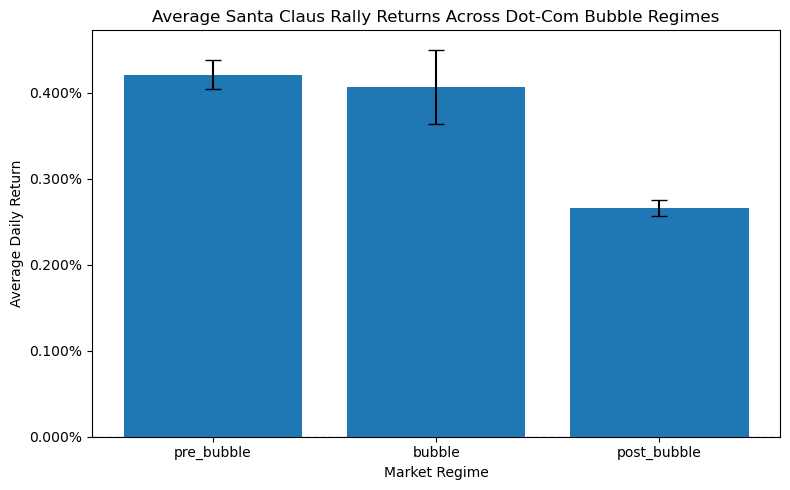

In [61]:
plot_scr_bubble_average(scr_df)

The Santa Claus Rally did not disappear during the dot-com bubble, but it lost a large part of its strength afterward.

### Financial Crisis

In [49]:
scr_df = df[df["Is_SCR"] == 1]
scr_pre = scr_df[scr_df["financial_crisis"] == "pre_crisis"]["Return"]
scr_crisis = scr_df[scr_df["financial_crisis"] == "crisis"]["Return"]
scr_post = scr_df[scr_df["financial_crisis"] == "post_crisis"]["Return"]

In [50]:
print(len(scr_pre), len(scr_crisis), len(scr_post))

310511 46679 324111


In [52]:
calculate_welch_t_test(scr_pre, scr_crisis, effect_name="Santa Claus Rally: pre Crisis vs during Crisis")
calculate_welch_t_test( scr_crisis, scr_post, effect_name="Santa Claus Rally: during Crisis vs post crisis")
calculate_welch_t_test( scr_pre, scr_post, effect_name="Santa Claus Rally: pre Crisis vs post crisis")

[Santa Claus Rally: pre Crisis vs during Crisis] T-test: -13.4538, P-value: 0.0000
[Santa Claus Rally: during Crisis vs post crisis] T-test: 18.5126, P-value: 0.0000
[Santa Claus Rally: pre Crisis vs post crisis] T-test: 13.0602, P-value: 0.0000


Unlike speculative bubbles, financial crises have an immediate and severe impact on the Santa Claus Rally. Returns during crisis periods are significantly lower than in pre-crisis markets, indicating a temporary breakdown of the effect. However, this disruption does not persist: post crisis returns not only recover but exceed their pre crisis levels. This pattern suggests that the Santa Claus Rally is highly sensitive to periods of extreme uncertainty, yet resilient once market confidence is restored.

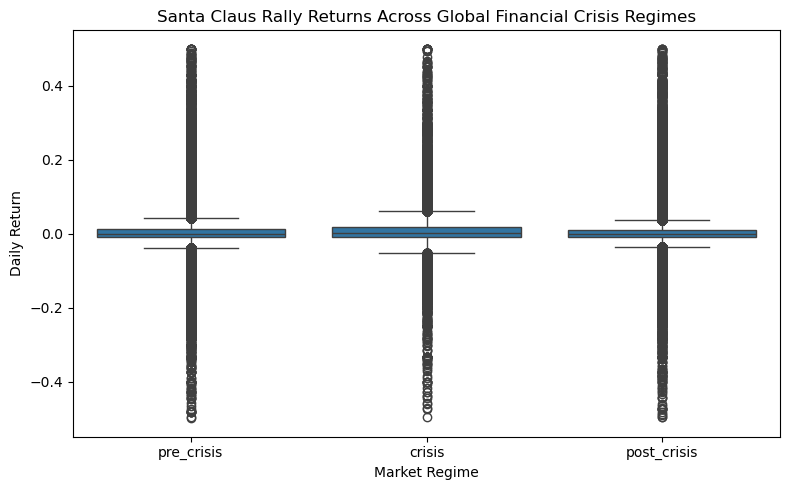

In [53]:
plot_scr_crisis(scr_df)

The entire distribution during the crisis appears higher than both pre and post crisis periods.

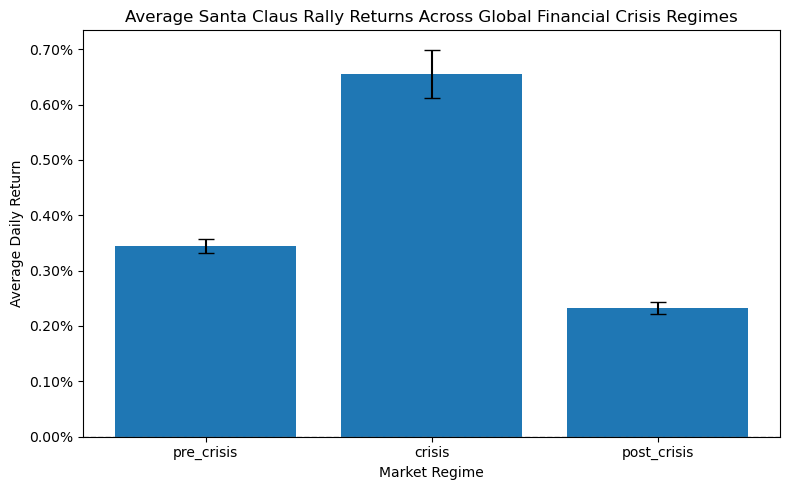

In [54]:
plot_scr_crisis_average(scr_df)

Average daily Santa Claus Rally returns across Global Financial Crisis regimes reveal a pronounced increase during the crisis period, followed by a post crisis decline. The limited overlap of 95% confidence intervals suggests statistically meaningful period differences, consistent with Welch and Mann–Whitney test results. These findings indicate that the Santa Claus Rally is not only persistent but moving in the opposite direction of the overall market cycle, strengthening during periods of elevated market stress.

# Holiday Effect

The holiday effect is a market anomaly. Stock returns tend to be higher during the trading days immediately before public holiday. It was first studied in the 1930s and later formalized in 1987. In order to determine the phenomenon's veracity, the nasdaq stock will be studied with the us holiday public days. The analyses will be run for different periods, from early years of the nasdaq stock until 2020 to see how persistent it is and if it applies to the nasdaq stock. The us holiday include Christmas day, New year's day, Memorial day, and others. Therefore, by comparing average returns observed immediately before holidays with those from regular trading days, it is expected to be higher during the days just before. 

In [2]:
from src.scripts.holiday_effect import  plot_holiday_effect_exchange, hypothesis_test_pre_holiday_effect, normality_check, plot_crisis_holiday_heatmap, plot_preholiday_vs_normal_by_holiday, plot_holiday_effect_by_decade_comparison

In [52]:
# Separate groups
df["pre_holiday_mask"] = df["holiday_period"].astype(str).str.startswith("before_", na=False)
pre_holiday_returns = df[df["pre_holiday_mask"]]['Return'].dropna()
normal_returns = df[~df["pre_holiday_mask"]]['Return'].dropna()

In [53]:
check_normalitiy(pre_holiday_returns, "Pre-holiday Returns")
check_normalitiy(normal_returns, "Days that are not holidays Returns")

[Pre-holiday Returns] Stat: 269473.9261
[Pre-holiday Returns] P-value: 0.0000
[Days that are not holidays Returns] Stat: 8186597.7539
[Days that are not holidays Returns] P-value: 0.0000


In [54]:
calculate_welch_t_test(pre_holiday_returns, normal_returns, "Holiday Effect")

[Holiday Effect] T-test: 45.4908, P-value: 0.0000


In [55]:
calculate_mannwhitneyu(pre_holiday_returns, normal_returns, "Holiday Effect")

[Holiday Effect] mannwhitneyu-test: 6211308568991.5000, P-value: 0.0000


Normality tests reject the null hypothesis for holiday and non-holiday returns, indicating that returns are not normally distributed. This is consistent with financial return data and justifies the use of a Welch t-test, which is robust to non-normality and unequal variances.

At the 5% significance level, the null hypothesis of equal mean returns is rejected in favor of the one-sided alternative. This provides statistically significant evidence of a higher average return on days before holiday, consistent with the holiday effect documented in the descriptive analysis.

The Mann–Whitney U test yields a highly significant result (p-value ≈ 0.0000), indicating that the distribution of returns on holidays is significantly different from that of non-holidays. This provides strong evidence in favor of a Holiday effect.

In [56]:
m5 = run_ols(df, effect_col="pre_holiday_mask", controls=["fed_funds"], mode="ts", hac_lags=6)
m6 = run_ols(df, effect_col="pre_holiday_mask", controls=["volatility","Volume"], mode="cluster")

In [57]:
print(m5.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     21.24
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           6.17e-10
Time:                        23:11:42   Log-Likelihood:                 48899.
No. Observations:               14643   AIC:                        -9.779e+04
Df Residuals:                   14640   BIC:                        -9.777e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0006   8.42e-05  

The coefficient is positive and highly significant (≈ +0.25%, p < 0.001), indicating that returns are significantly higher on pre-holiday days compared to regular days. The coefficient is not statistically significant (p = 0.541), suggesting that interest rate levels do not explain the Holiday effect in this specification. The Holiday effect remains statistically significant and positive, even after controlling for the federal funds rate.


In [58]:
print(m6.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.925
Date:                Sun, 21 Dec 2025   Prob (F-statistic):            0.00204
Time:                        23:11:48   Log-Likelihood:             4.7134e+07
No. Observations:            24017456   AIC:                        -9.427e+07
Df Residuals:                24017452   BIC:                        -9.427e+07
Df Model:                           3                                         
Covariance Type:              cluster                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0005      0.000  

The coefficient is positive and statistically significant (≈ +0.20%, p = 0.001), indicating higher returns on pre-holiday days compared to non-holiday days. Both coefficients volatility and volume are not statistically significant, suggesting they do not drive the Holiday effect. The Holiday effect remains positive and significant, even after controlling for volatility and trading volume.

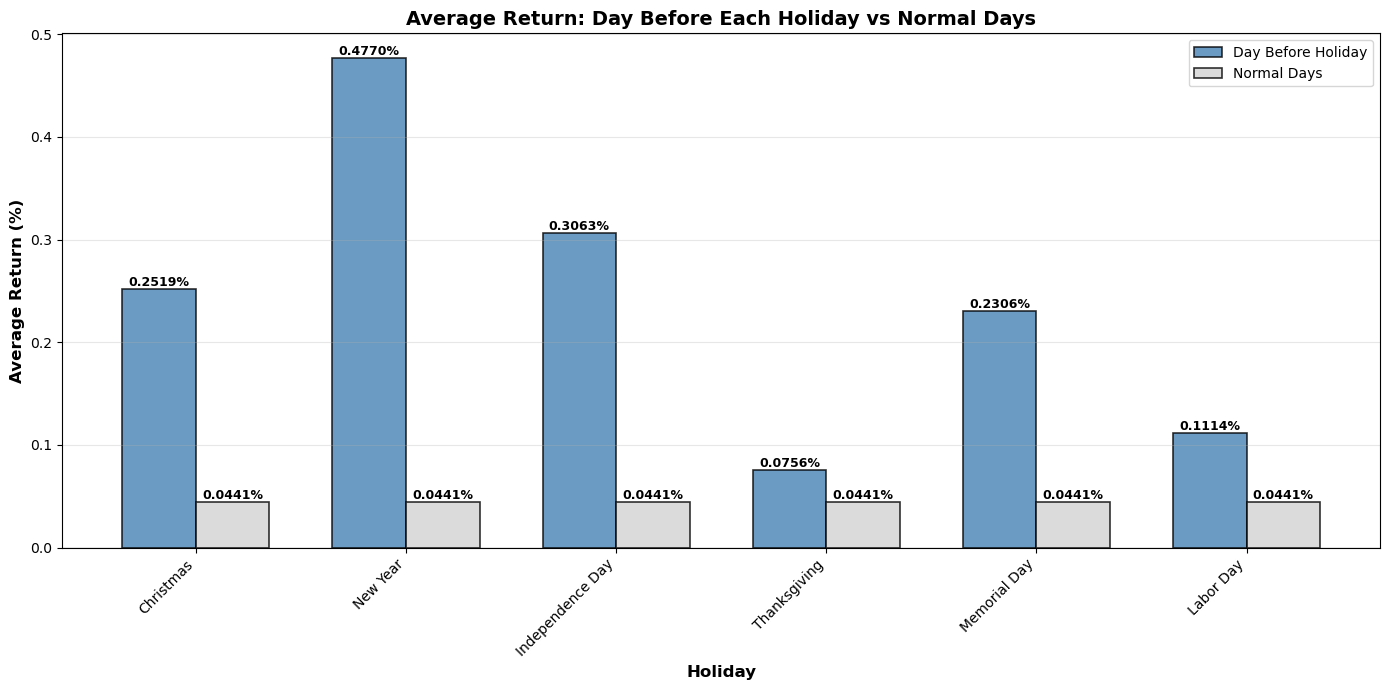

Christmas                0.2519%          0.2078%
New Year                 0.4770%          0.4329%
Independence Day         0.3063%          0.2622%
Thanksgiving             0.0756%          0.0315%
Memorial Day             0.2306%          0.1865%
Labor Day                0.1114%          0.0673%
            Holiday  Day Before Return (%)  Normal Days Return (%)  \
0         Christmas               0.251878                0.044107   
1          New Year               0.477029                0.044107   
2  Independence Day               0.306298                0.044107   
3      Thanksgiving               0.075638                0.044107   
4      Memorial Day               0.230618                0.044107   
5         Labor Day               0.111405                0.044107   

   Difference (%)  
0        0.207771  
1        0.432922  
2        0.262191  
3        0.031530  
4        0.186511  
5        0.067298  


In [ ]:
plot_preholiday_vs_normal_by_holiday(df)

Every holiday exhibits a positive pre-holiday premium relative to normal trading days. However, the magnitude of the effect varies substantially across holidays. The effect is especially pronounced before New Year, which records by far the highest average return on the preceding trading day, suggesting strong seasonal optimism or year-end positioning by investors. Independence Day and Christmas also display a robust pre-holiday effect, with average returns several times higher than those observed on normal days. These holidays are often associated with reduced trading activity and a generally positive market sentiment, which may amplify price movements.

Based on these initial findings, it would be intuitive to assume that the holiday effect persists uniformly over time, including in more recent years. However, given the increasing efficiency of financial markets and the growing prevalence of algorithmic trading, an important question arises: does the holiday effect remain as strong in recent decades, or has it weakened over time? To address this issue, the following analysis examines the evolution of the holiday effect across different decades.


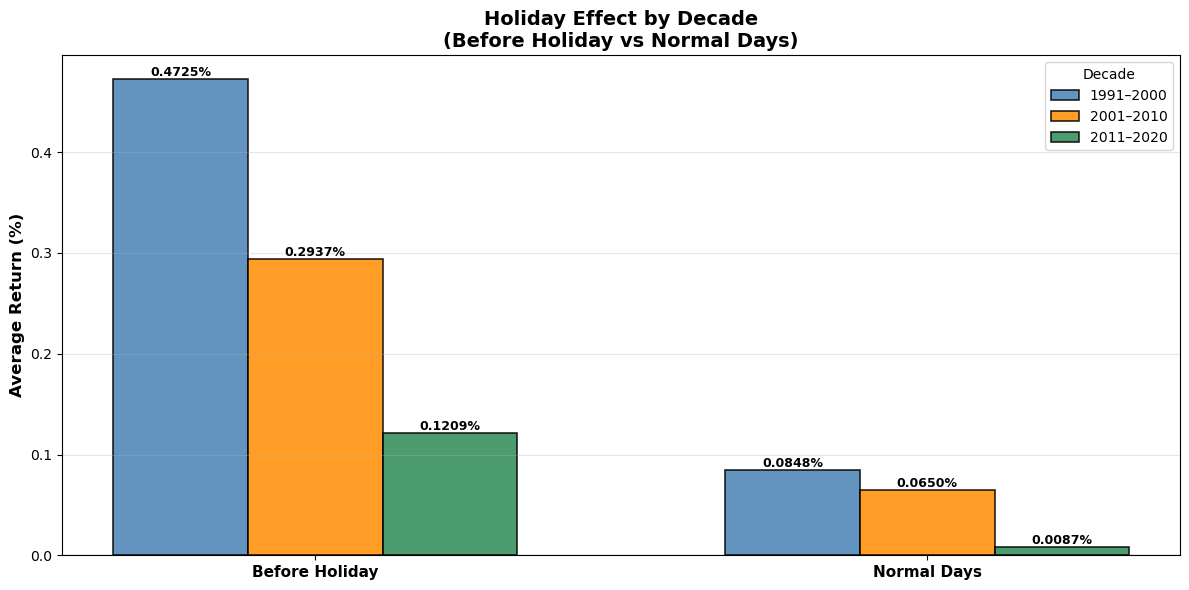

In [3]:
plot_holiday_effect_by_decade_comparison(df)

From the plot of holiday effect through three different decades, it is clear that the holiday effect has not remained constant over time. While the holiday effect is observable in all decades, its magnitude declines sharply as markets evolve. 

During the 1991–2000 period, the holiday effect is particularly strong. The average return on the day preceding a holiday reaches approximately 0.47%, compared to about 0.08% on normal trading days. This large differential highlights a pronounced calendar anomaly during this decade, when market inefficiencies were more easily exploitable. In the 2001–2010 decade, the effect remains significant but is noticeably weaker: the economic relevance of the holiday effect is diminishing. The 2011–2020 period shows a further attenuation of the holiday effect. The average pre-holiday return drops to around 0.12%, and returns on normal days become almost negligible. The gap between day before holiday and normal days is much narrower, indicating that the anomaly has largely weakened in recent years: the market has adapted. 

A plausible explanation lies in the increasing efficiency of financial markets, driven by better knowledge diffusion and the rise of algorithmic and high-frequency trading strategies. As such anomalies become widely documented, they are more likely to be arbitraged away. An important question remains: does this attenuation occur uniformly across US exchanges ? To address this issue, the following analysis examines the holiday effect across different U.S. exchanges.


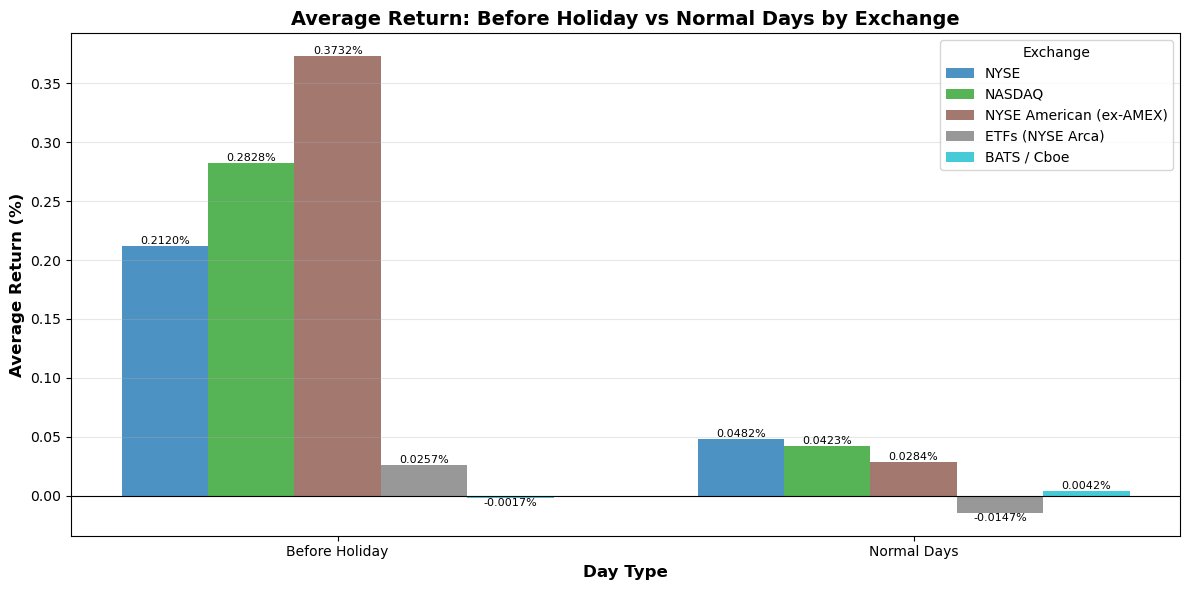

In [8]:
plot_holiday_effect_exchange(df)


Holiday-related return differences vary widely across exchanges. The effect appears strongest on NASDAQ and NYSE American, where returns tend to be higher the day before holiday, while the NYSE exhibits a more modest increase. In contrast, ETFs and BATS/Cboe show little to no noticeable holiday effect, suggesting that this pattern is mainly concentrated in traditional equity markets.

These cross-exchange differences raise a further question: is the holiday effect robust during periods of extreme market stress, or does it break down during major financial crises? Since crises are characterized by heightened volatility, liquidity constraints, and shifts in investor behavior, examining returns around holidays during such episodes provides a natural stress test of the anomaly


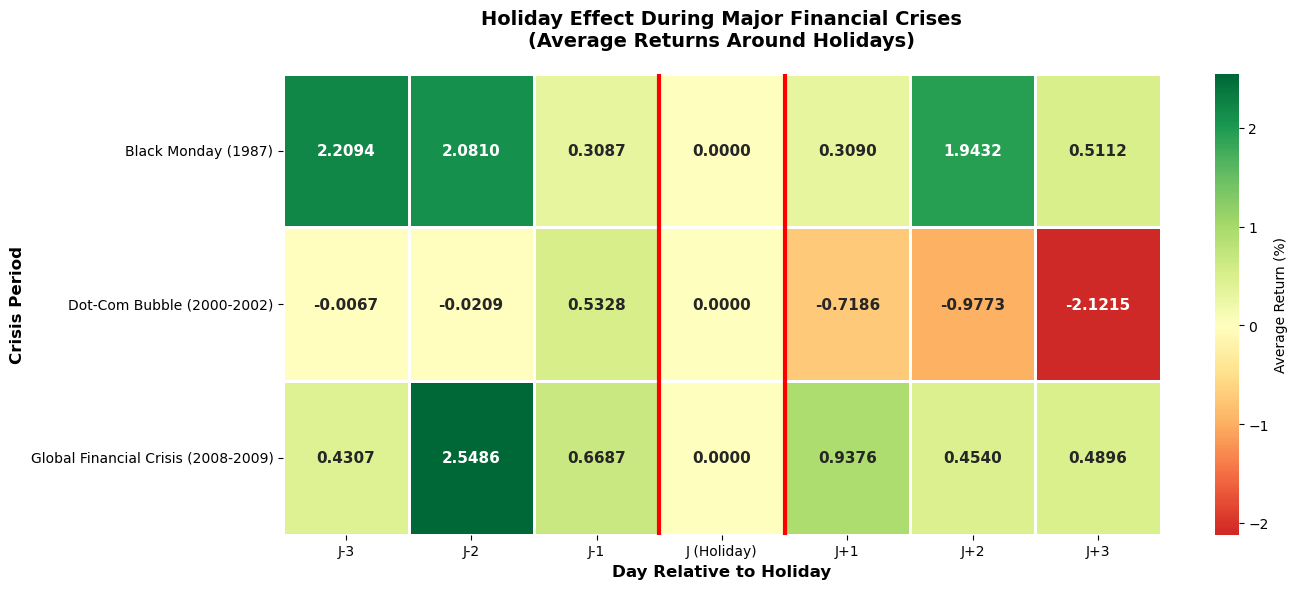


Black Monday (1987):
  Pre-holiday average (J-3 to J-1):  1.5330%
  Post-holiday average (J+1 to J+3): 0.9212%
  J-1 (day before holiday):          0.3087%

Dot-Com Bubble (2000-2002):
  Pre-holiday average (J-3 to J-1):  0.1684%
  Post-holiday average (J+1 to J+3): -1.2724%
  J-1 (day before holiday):          0.5328%

Global Financial Crisis (2008-2009):
  Pre-holiday average (J-3 to J-1):  1.2160%
  Post-holiday average (J+1 to J+3): 0.6271%
  J-1 (day before holiday):          0.6687%



,J-3,J-2,J-1,J (Holiday),J+1,J+2,J+3
Black Monday (1987),2.209390,2.081032,0.308653,0,0.309039,1.943217,0.511228
Dot-Com Bubble (2000-2002),-0.006657,-0.020878,0.532835,0,-0.718558,-0.977276,-2.121509
Global Financial Crisis (2008-2009),0.430700,2.548555,0.668676,0,0.937619,0.454016,0.489630


In [4]:
plot_crisis_holiday_heatmap(df)

The holiday effect is not eliminated during financial crises, but its magnitude and persistence depend on the nature of the crisis. Returns in the days preceding holidays (J-1, J-2) are often positive, even in turbulent periods. 
Indeed, during Black Monday (1987), returns are strongly positive in the days leading up to the holiday, particularly at J-3 and J-2, reflecting extreme volatility and rapid price reversals during this episode Returns in the days preceding holidays (J-1, J-2) are often positive, even in turbulent periods: it suggests that holiday effect still persists. Besides, for the Global Financial Crisis (2008–2009), the holiday effect appears very resilient. In contrast, the Dot-Com Bubble (2000–2002) shows a markedly different pattern. B. While the day before the holiday (J-1) still exhibits a positive return, post-holiday returns (J+1 to J+3) turn sharply negative. This asymmetry suggests that during prolonged downturns driven by fundamental revaluations, the holiday effect becomes weaker and is quickly dominated by negative market sentiment. This reinforces the view that the holiday effect is shaped by investor sentiment, market stress.

The observed differences could be attributed to random variation. To go further, the next step consists in conducting formal hypothesis tests to determine whether the pre-holiday returns are statistically different from normal-day returns. This inferential analysis will allow us to verify whether the holiday effect represents a genuine and persistent market anomaly.


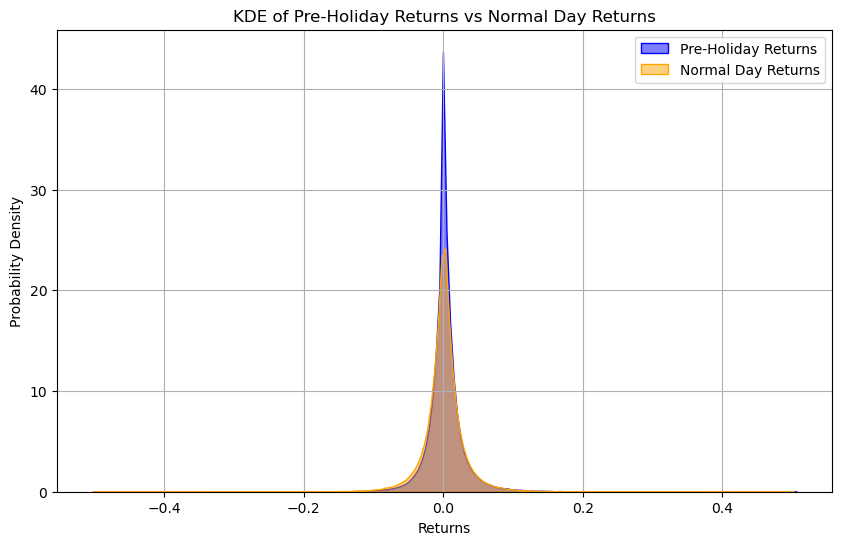

In [5]:
normality_check(df)

Before proceeding with formal hypothesis testing, it is essential to verify whether the data satisfy the underlying assumptions required for statistical inference, in particular the assumption of normality. The shape is clearly non Gaussian. That said, as stated before, given the large sample, which is way more than 100. the Central Limit Theorem justifies the use of parametric tests such as the t-test on mean differences. In addition to the normality consideration, the other assumptions required for t-test hypothesis testing, which are independence of observations and finite variance are reasonably satisfied in the context of daily return data, making the application of the test appropriate.

In [6]:
hypothesis_test_pre_holiday_effect(df)

Hypothesis test
H₀: μ_return_pre-holiday = μ_return_normal
H₁: μ_return_pre-holiday > μ_return_normal (one-tailed)

p-value: 0.000000

Decision ( α = 0.05):
 We reject the null hypothesis and find statistically significant evidence that average stock returns on pre-holiday trading days are higher than returns on regular trading days (p = 0.000000)


np.float64(0.0)

At the 5% significance level, the null hypothesis of equal mean returns is rejected in favor of the one-sided alternative. This provides statistically significant evidence of a higher average return on days before holiday, consistent with the holiday effect documented in the descriptive analysis.
In sum, the analyses supports the presence of a statistically significant holiday effect. Although its magnitude has declined over time, the anomaly persists across different market environments, suggesting that calendar effects continue to play a role in asset 

## Sell In May Effect (Halloween Effect)

The Sell in May effect, also known as the Halloween effect, is a seasonal pattern in stock markets. It suggests that stock returns are usually higher in the winter period (November–May) than in the summer period (May–November). In this analysis, we compare the returns of these two periods to see whether this pattern appears in the NASDAQ market.

In [2]:
from src.scripts.sell_in_may import (
    compute_log_returns, sell_in_may_report_plot, sell_in_every_month_plot,
    make_equal_weight_monthly_index, backtest_sell_in_may_plot, sell_in_may_report_with_fed,
    predict_market_direction, regression_analysis_seasonality, risk_adjusted_analysis,
    regression_with_fed, sell_in_may_fed_tightening, 
    sell_in_may_volatility_regime, sell_in_may_fed_regime, plot_month_year_heatmap,
    plot_seasonal_distribution, plot_spread_by_vol_regime, plot_vol_regime_point_ci,
    analyze_sell_in_may_effect, analyze_sell_in_may_during_crisis,
    plot_sell_in_may_effects_across_crises, compare_by_decades, analyze_low_and_high_impact,
    plot_affected_years_pie_chart, plot_seasonality_for_ticker, compare_by_exchange
)

In [59]:
summer_returns, winter_returns = get_summer_winter_returns(df)
check_normalitiy(summer_returns, "Summer Returns")
check_normalitiy(winter_returns, "Winter Returns")

[Summer Returns] Stat: 3.0270
[Summer Returns] P-value: 0.2201
[Winter Returns] Stat: 0.8997
[Winter Returns] P-value: 0.6377


In [60]:
calculate_welch_t_test(summer_returns, winter_returns, "Sell in May effect")

[Sell in May effect] T-test: -4.0670, P-value: 0.0001


In [61]:
calculate_mannwhitneyu(winter_returns, summer_returns, "Sell in May effect")

[Sell in May effect] mannwhitneyu-test: 2442.0000, P-value: 0.0000


We first check if summer and winter returns look normal. For both groups, the p-values are above 0.05, so normality is not rejected. We then compare average returns using Welch’s t-test. The test shows a clear difference between winter and summer returns. Winter returns are higher. We also run a Mann–Whitney test. This test gives the same conclusion. Overall, the results support the Sell in May effect.

In [62]:
df["is_winter"] = df["Month"].isin([11,12,1,2,3,4]).astype(int)
m7 = run_ols(df, effect_col="is_winter", controls=["fed_funds"], mode="ts", hac_lags=6)
m8 = run_ols(df, effect_col="is_winter", controls=["volatility","Volume"], mode="cluster", hac_lags=6)

In [63]:
print(m7.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.931
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           0.000361
Time:                        23:14:20   Log-Likelihood:                 48897.
No. Observations:               14643   AIC:                        -9.779e+04
Df Residuals:                   14640   BIC:                        -9.776e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      2.693      0.0

We regress returns on a winter months (Nov–Apr) and control for the Fed Funds rate. The winter coefficient is positive and statistically significant, indicating that returns are higher during winter months. The Fed Funds rate is not significant, meaning that this seasonal pattern is not driven by interest rate conditions.

In [64]:
print(m8.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.141
Date:                Sun, 21 Dec 2025   Prob (F-statistic):             0.0928
Time:                        23:14:27   Log-Likelihood:             4.7134e+07
No. Observations:            24017456   AIC:                        -9.427e+07
Df Residuals:                24017452   BIC:                        -9.427e+07
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.676      0.0

We add volatility and trading volume as controls in the regression. The winter coefficient is still positive, but it is weaker and less significant. This means that higher winter returns are partly linked to changes in market volatility and trading activity,
rather than seasonality alone.

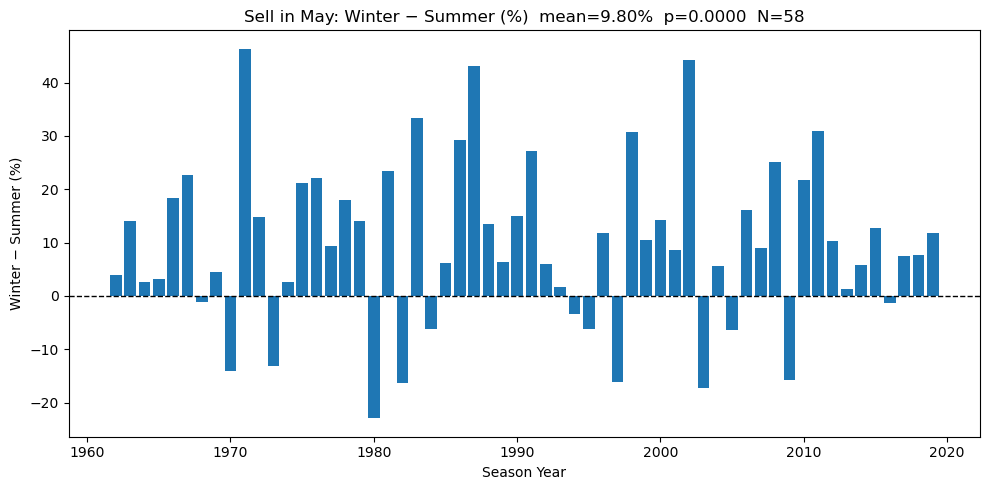

In [3]:
sell_in_may_report_plot(df)

The figure shows the yearly return difference between the winter period (November–May) and the summer period (May–November). This difference is the main idea behind the Sell in May effect. The data covers 58 years. In 45 years, winter returns are higher than summer returns, while in 13 years the opposite happens. From this visual result, we can already see that winter returns are usually higher than summer returns in the NASDAQ market.

To support this observation, a one-sample t-test is applied. The test checks whether the average difference between winter and summer returns is equal to zero. The obtained p-value is about 0.0001, which is much smaller than 0.05. Therefore, we reject the null hypothesis. This result shows that the higher winter returns are not due to random chance. In conclusion, the Sell in May (also called the Halloween) effect is clearly observed in the NASDAQ data.

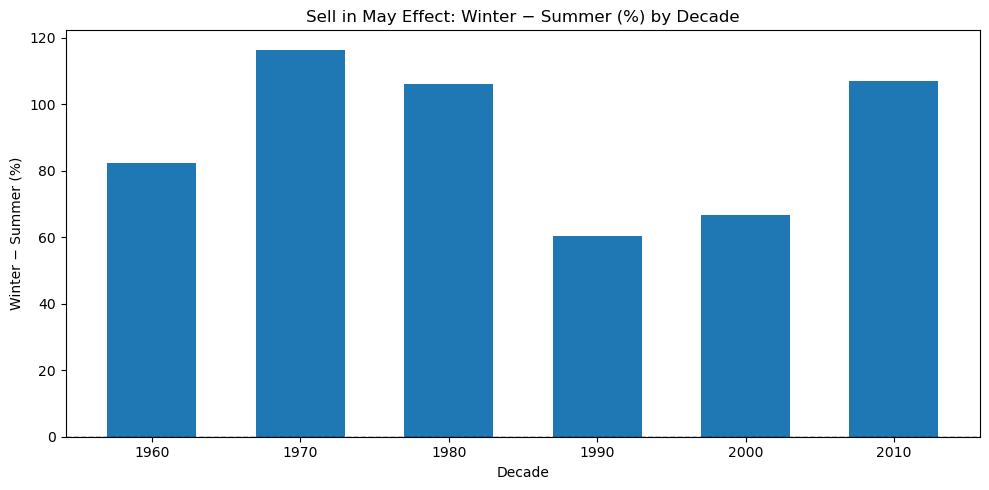

Season,summer,winter
Decade,,
1960,0.152041,0.75185
1970,0.007218,0.77921
1980,0.490555,1.213037
1990,0.57763,1.050632
2000,0.385923,0.897336
2010,0.026721,0.754934


In [7]:
compare_by_decades(df)

This bar chart shows the Sell in May effect by decade. Each bar represents the total difference between winter and summer returns for a given decade.

From the figure, we can see that the winter–summer return difference is positive in all decades. This means that winter returns are higher than summer returns across different time periods. The strength of the effect changes over time, with stronger differences in the 1970s, 1980s, and 2010s, and weaker differences in the 1990s and 2000s.

Overall, the chart suggests that the Sell in May effect is persistent across decades, even though its magnitude varies over time.

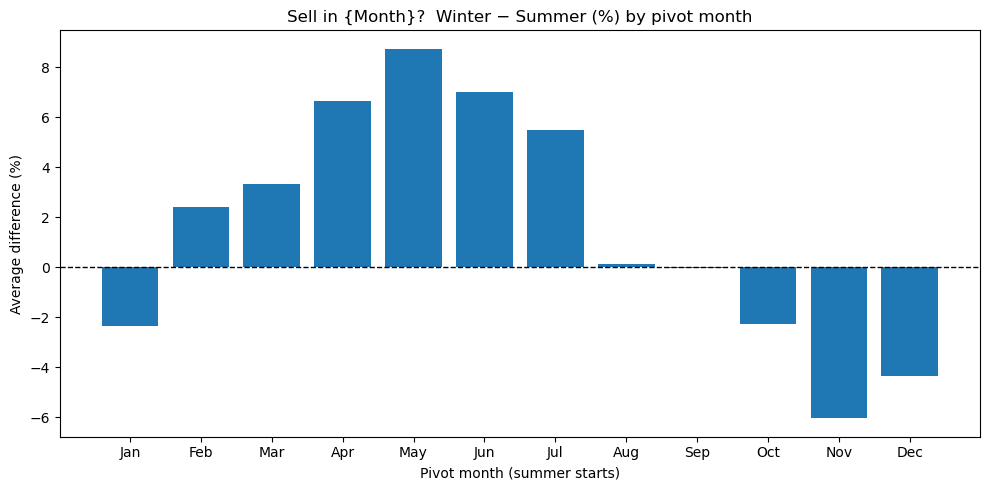

In [4]:
sell_in_every_month_plot(df)

After observing the Halloween effect, we ask a new question: can this effect be improved by changing the pivot month? In this analysis, we shift the month where the summer period starts and compute the winter–summer return difference for each case.

From the figure, we can clearly see that May gives the highest average difference. The return gap peaks around May, which means that starting the summer period in May leads to the strongest winter–summer performance gap. Months close to May, such as April and June, also show relatively high values, but May stands out as the best cutoff month.

In contrast, pivot months like November and December show negative differences. This means that defining the winter period with these months leads to weaker performance. Overall, the results confirm that May is the optimal pivot month, supporting the traditional Sell in May strategy.

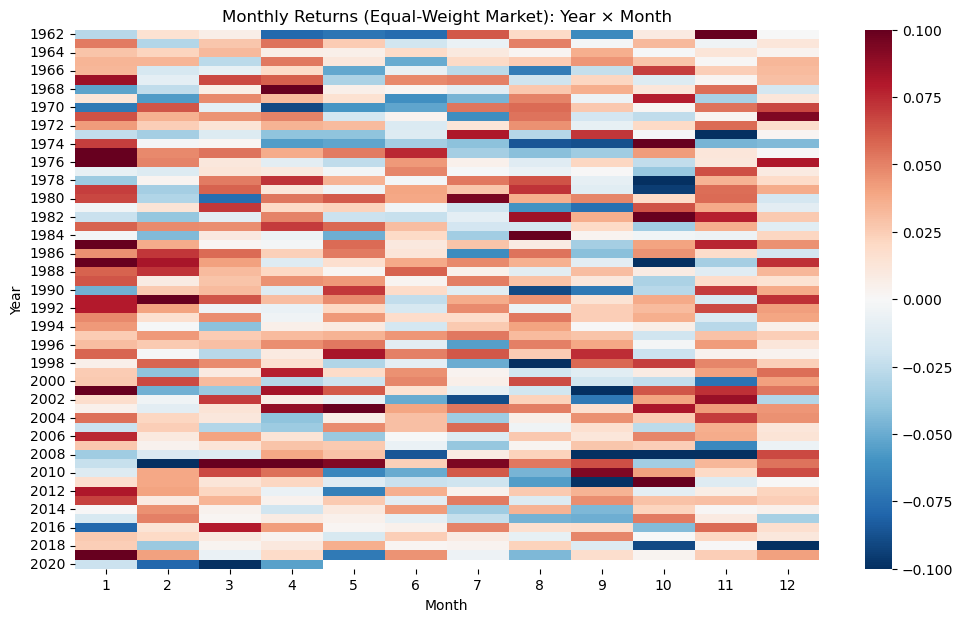

In [3]:
plot_month_year_heatmap(df)

This heatmap shows monthly market returns across different years. The colors represent average returns, where red indicates positive returns and blue indicates negative returns.

From the figure, we can see clear differences across months and years. Some months show more frequent positive returns, while others are more mixed or negative. This visual pattern supports the idea that returns are not evenly distributed over the calendar year. In particular, months in the winter period tend to show stronger and more stable performance compared to many summer months.

Overall, the heatmap shows that monthly returns change depending on the season.

c:\Users\FURKAN\Documents\DataScience\ada-2025-project-farzmcollective2025-main\src\scripts\sell_in_may.py:485: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Season", y="Return", data=m, inner="box", palette="Set2")


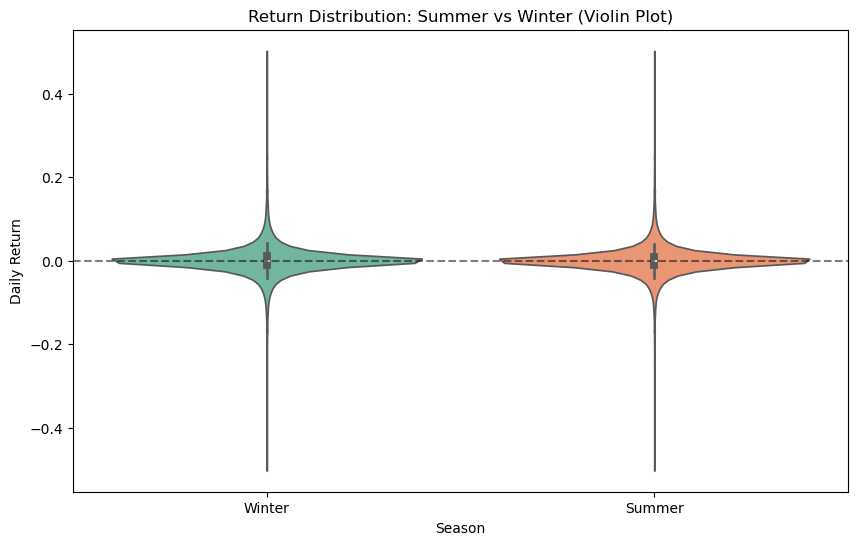

In [4]:
plot_seasonal_distribution(df)

This violin plot compares the distribution of returns in winter and summer. From the figure, we can see that the two distributions are quite similar. Both seasons show comparable spread and shape, and there is no clear visual separation between them.

Although the average winter return appears slightly higher, the difference is small and not very strong at this level.

RISK-ADJUSTED STATISTICS
            mean       std     count    sharpe
Season                                        
summer  0.000258  0.032794  12171061  0.125107
winter  0.000742  0.035298  11964240  0.333769


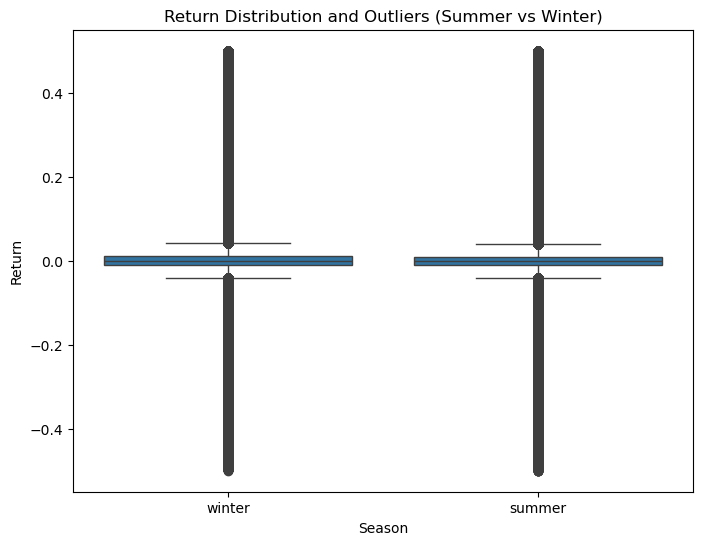

In [7]:
risk_adjusted_analysis(df)

The table shows risk-adjusted statistics for summer and winter returns. Winter has a higher average return and a higher Sharpe ratio than summer. This means that winter provides better return per unit of risk.

The boxplot compares the return distributions and outliers for both seasons. From the figure, we can see that the two distributions are very similar and have many outliers on both sides. However, the center of the winter distribution is slightly higher than that of summer.

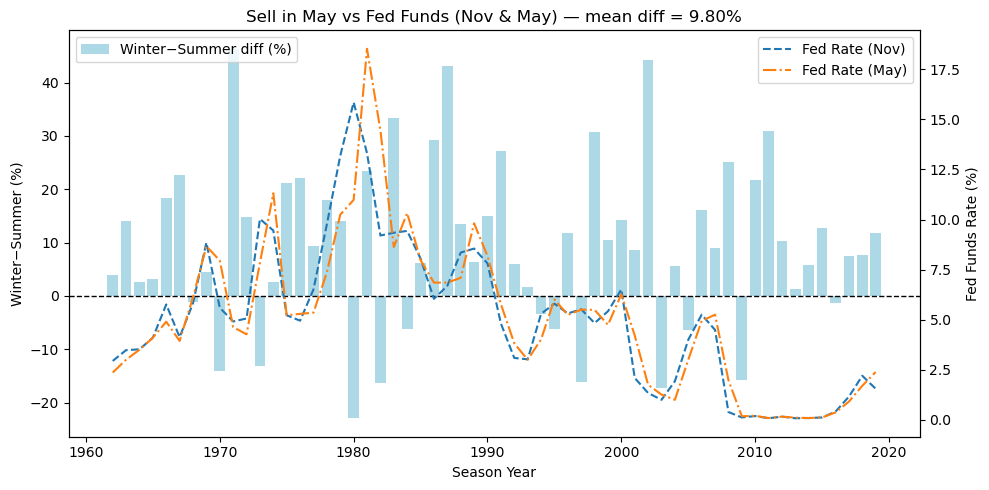

In [8]:
sell_in_may_report_with_fed(df)

In this part, we use the same Winter–Summer return difference as in the previous Sell in May analysis. In addition, we include the Fed Funds rate in November and May for each year. The goal is to see whether interest rates are related to the strength of the Sell in May effect.

From the figure, there does not seem to be a clear correlation between interest rates and the Winter–Summer return difference. However, one interesting observation is that when the interest rate is higher than about 7.5%, the Sell in May effect appears to be weaker.

To better understand this relationship, a more detailed analysis will be carried out in the next step.

SELL IN MAY × VOLATILITY REGIME
                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.339
Date:                Sun, 21 Dec 2025   Prob (F-statistic):            0.00122
Time:                        22:44:52   Log-Likelihood:                 1147.8
No. Observations:                 689   AIC:                            -2288.
Df Residuals:                     685   BIC:                            -2269.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Inte

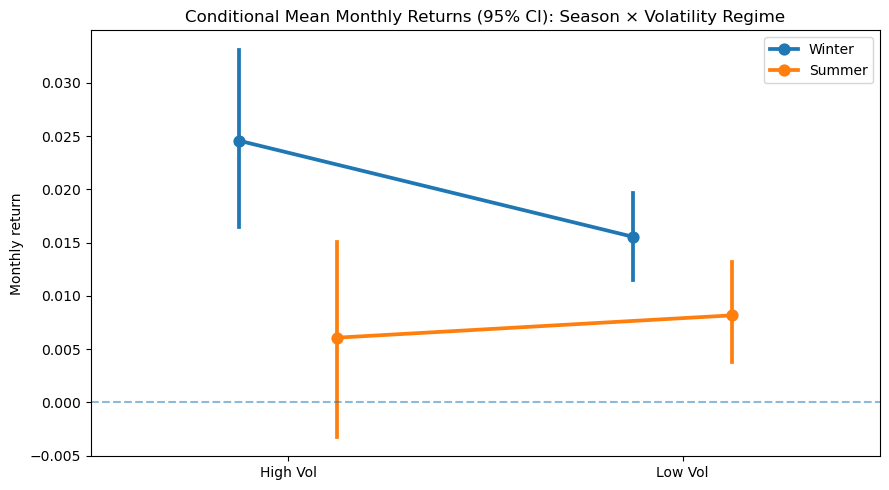

In [5]:
fed_path = "data/FEDFUNDS.parquet"
df_monthly, model = sell_in_may_volatility_regime(df, fed_path)
plot_vol_regime_point_ci(df_monthly)

This figure shows average monthly returns for winter and summer under different volatility conditions. The points represent the mean returns, and the vertical lines show the 95% confidence intervals. The dashed line marks zero return.

In both high-volatility and low-volatility periods, winter returns are higher than summer returns. The difference is larger during high-volatility periods, where winter returns are clearly positive while summer returns are close to zero. In low-volatility periods, the gap becomes smaller, but winter still performs better.

Overall, the figure suggests that the Sell in May effect is stronger when market volatility is high and weaker when volatility is low.

These findings are supported by the regression results, which indicate significantly higher returns during winter months and a stronger Sell in May effect in high-volatility regimes.

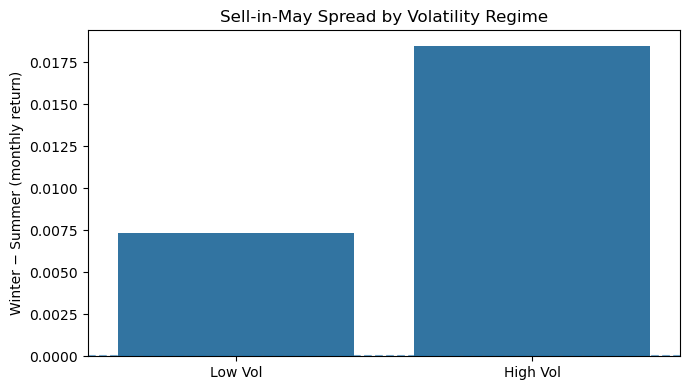

In [6]:
plot_spread_by_vol_regime(df_monthly)

This bar chart shows the Sell in May spread, defined as the difference between winter and summer monthly returns, under different volatility regimes.

From the figure, we can see that the spread is positive in both cases, which means winter returns are higher than summer returns in both low- and high-volatility periods. However, the spread is much larger during high-volatility periods. This indicates that the Sell in May effect becomes stronger when market volatility is high.

Overall, the chart confirms that volatility plays an important role in the strength of the Sell in May effect.

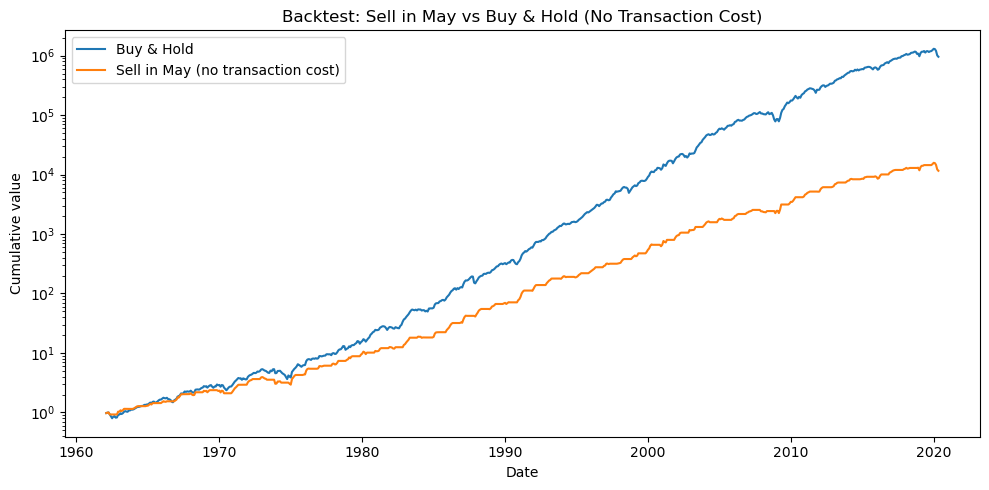

In [12]:
monthly_eq = make_equal_weight_monthly_index(df)
backtest_sell_in_may_plot(monthly_eq)

To better understand the practical impact, we run a simple backtest. We compare two strategies: Buy & Hold, where the investor stays invested all the time, and Sell in May, where the investor exits the market in May and re-enters in November. No transaction costs are included.

From the graph, we can clearly see that the Buy & Hold strategy strongly outperforms the Sell in May strategy over the full period. Although the seasonal return difference exists, leaving the market during summer causes the investor to miss many positive returns. As a result, selling in May does not lead to higher long-term performance in this setting.

Overall, this shows that the existence of a seasonal effect does not automatically imply a profitable trading strategy.

In [13]:
crisis_periods = {
        "Dot-Com Bubble (2000-2002)": ["2000-01-01", "2002-12-31"],
        "Black Monday (1987)": ["1987-01-01", "1987-12-31"],
        "Global Financial Crisis (2008-2009)": ["2008-01-01", "2009-12-31"]
    }
analyze_sell_in_may_during_crisis(df,crisis_periods)

,Crisis,Avg_Summer_Return,Avg_Winter_Return,Effect_Ratio (%)
0,Dot-Com Bubble (2000-2002),-0.097547,0.426862,75.605749
1,Black Monday (1987),-0.126572,0.255610,85.245902
2,Global Financial Crisis (2008-2009),-0.023340,0.179218,64.864865


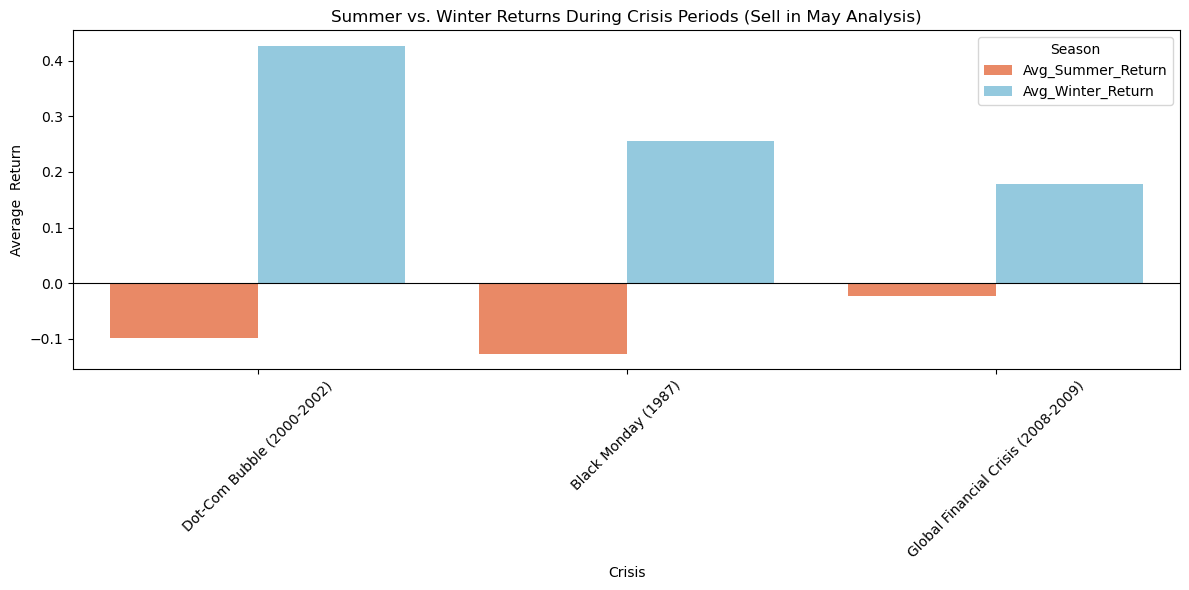

In [14]:
plot_sell_in_may_effects_across_crises(df, crisis_periods)

From the graph, we can see that winter returns are positive in all crisis periods, while summer returns are negative or close to zero. This pattern appears during the Dot-com Bubble, Black Monday, and the Global Financial Crisis.

Overall, the figure suggests that during crisis periods, winter performs much better than summer. This means that the Sell in May (Halloween) effect becomes more visible in times of market stress.

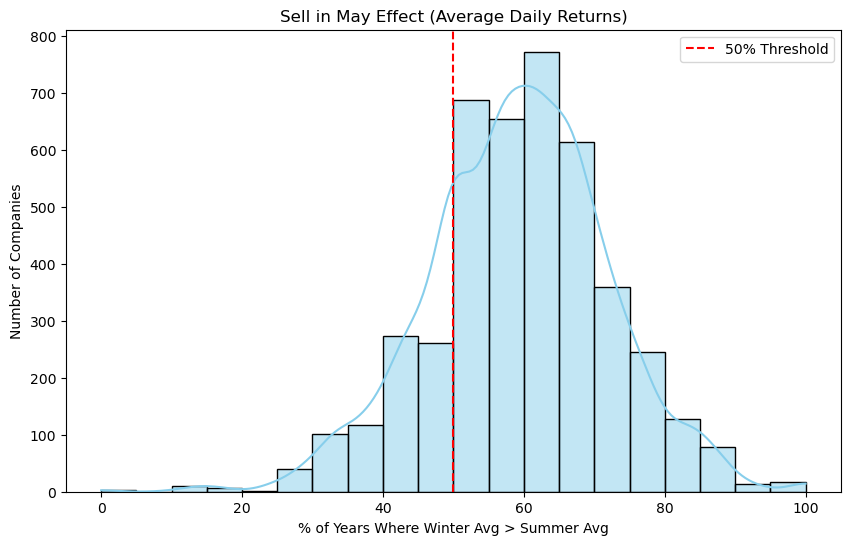

In [3]:
result_df = analyze_sell_in_may_effect(df)

In this figure, we look at how consistently each company follows the Sell in May effect during the time it is traded. For every company, we calculate the percentage of years in which the average winter return is higher than the average summer return.

The histogram shows the distribution of these percentages across all companies. The red dashed line marks the 50% level. Most companies are located to the right of this line, meaning that for more than half of the years, winter returns are higher than summer returns.

Overall, this result shows that the Sell in May effect is not  valid by only a few firms. Instead, it appears across many companies and holds for a majority of their trading years.

In [16]:
result_df_sorted = result_df.sort_values(by="Affected Years (%)", ascending=False)
print(result_df_sorted.head(20))

     Company  Affected Years (%)
1675   GFNCP              100.00
1398     ETX              100.00
1140    DLPH              100.00
2472     MCV              100.00
1993     IBP              100.00
958     CRTO              100.00
2815     NMS              100.00
523     BLMN              100.00
1820       H              100.00
1146     DMB              100.00
3913    TNET              100.00
2942    OCUL              100.00
92       AFT              100.00
1266     EFF              100.00
1268     EFR              100.00
2008     IDE              100.00
258     ARDC              100.00
1270     EFT               93.75
1473     FCT               93.75
470      BGT               93.75


Analyzing OCUL from 2014 to 2019 (Full years only)


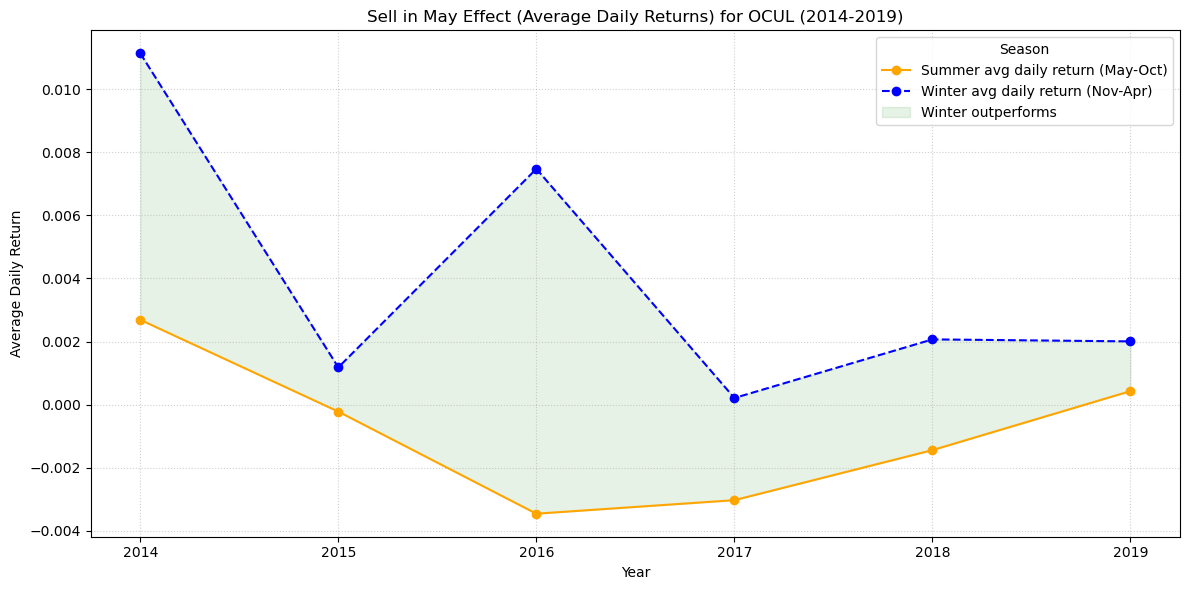

Season,Summer,Winter
Year,,
2014,0.002689,0.011141
2015,-0.000223,0.00118
2016,-0.003461,0.007478
2017,-0.003032,0.000209
2018,-0.001444,0.002068
2019,0.000428,0.002005


In [17]:
plot_seasonality_for_ticker(df, "OCUL")

This figure shows the Sell in May effect for a single company (OCUL) over the years it is traded. For each year, we compare the average daily return in winter (November–April) with the average daily return in summer (May–October).

In this case, winter returns are higher than summer returns in all available years. This means that the company follows the Sell in May pattern 100% of the time during the analyzed period. In other words, for every year in the sample, winter outperforms summer for this stock.

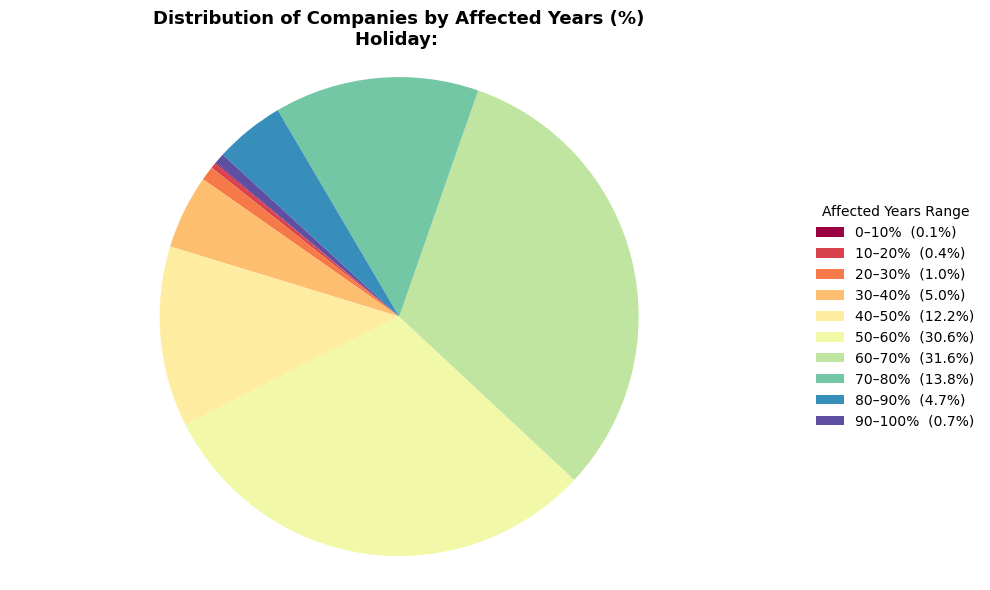

Range
0–10%         3
10–20%       16
20–30%       42
30–40%      219
40–50%      535
50–60%     1342
60–70%     1386
70–80%      606
80–90%      207
90–100%      31
Name: count, dtype: int64

In [4]:
plot_affected_years_pie_chart(result_df)

This pie chart shows how companies are distributed based on the percentage of years in which they are affected by the calendar effect. Each slice represents a range of affected years.

Most companies fall into the 50–70% range. This means that for the majority of firms, the effect appears in more than half of their trading years. Only a very small number of companies show very low or very high percentages.

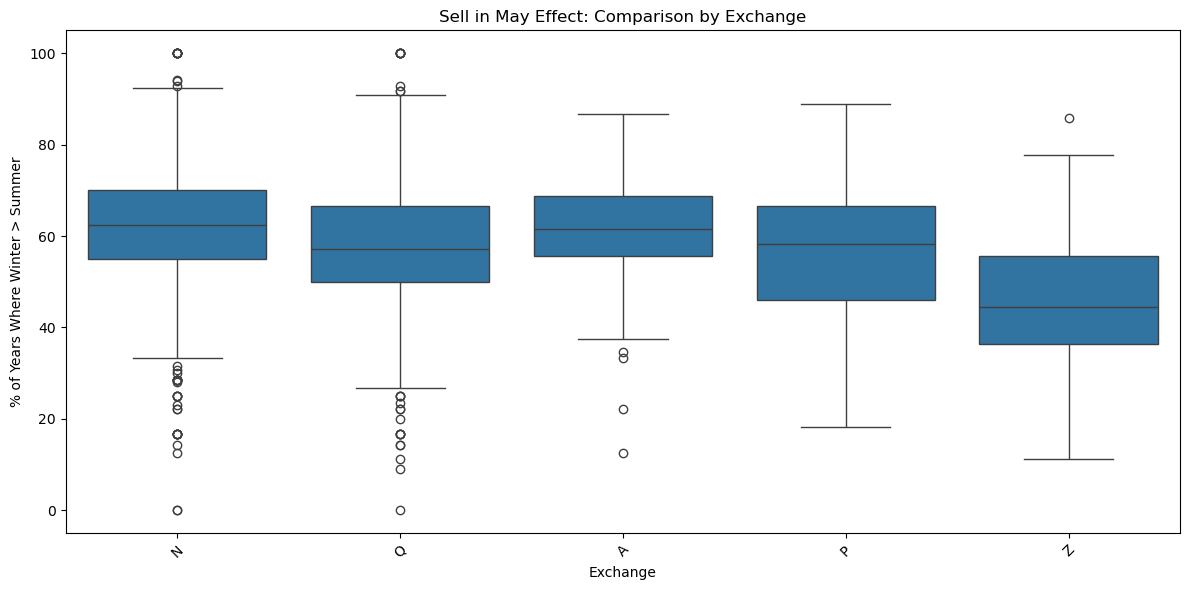

In [3]:
symbols_meta = pd.read_parquet('data/symbols_valid_meta.parquet')
symbols_meta = symbols_meta.rename(columns={'Symbol': 'Ticker'})
result_df = compare_by_exchange(df, symbols_meta, min_years=6)

This boxplot compares the Sell in May effect across different stock exchanges. For each exchange, the plot shows the distribution of the percentage of years in which winter returns are higher than summer returns.

From the figure, we can see that the median value is above 50% for most exchanges. This means that, on average, winter outperforms summer in more than half of the years across different markets. However, the spread differs by exchange, and some markets show more variation than others.

Overall, the results suggest that the Sell in May effect is present across exchanges, but its strength is not the same in every market.

CONCLUSION


In the Sell in May effect, stock returns are usually higher in winter months (November–April) than in summer months (May–October). In our data, this pattern appears clearly.

When we look at individual companies, most of them follow this pattern in more than 50% of their trading years. This shows that the effect is not driven by only a few firms. Instead, it appears across many companies and for a large part of their trading history.

We also check the effect using regressions. The winter period still shows higher returns even when interest rates are included. Interest rates themselves do not explain the difference between winter and summer returns.

Periods of high market volatility matter. During high-volatility times, the winter–summer return gap becomes larger. During calm periods, the gap is smaller but still positive.

## Turn of the Month

Let us now examine the existence of the turn-of-the-month and half-month effects. In other words, are stock market returns generally higher during these specific parts of the month compared with the rest of the month?
Let’s find out.

First, we need to define what we mean by turn of the month and half month.
For the turn-of-the-month period, we arbitrarily choose a 6-day window: the last 3 days of a month and the first 3 days of the following month.

For the half-month period, we also use a 6-day window. For example, in a 30-day month, the half-month period corresponds to days 14 through 18.

In [65]:
check_period_normality(df)

[ToM] Stat: 1098095.6400
[ToM] P-value: 0.0000
[Middle] Stat: 1019540.7384
[Middle] P-value: 0.0000
[Rest] Stat: 6317455.9234
[Rest] P-value: 0.0000


In [66]:
tom = df.loc[df["period_month_general"] == "ToM", "Return"]
rest = df.loc[df["period_month_general"] == "Rest", "Return"]
mid = df.loc[df["period_month_general"] == "Middle", "Return"]

In [67]:
calculate_welch_t_test(tom, rest, "Turn of the month effect")
calculate_welch_t_test(mid, rest, "Middle of the month effect")

[Turn of the month effect] T-test: 38.2926, P-value: 0.0000
[Middle of the month effect] T-test: 2.8484, P-value: 0.0044


In [68]:
calculate_mannwhitneyu(tom, rest, "Turn of the month effect")
calculate_mannwhitneyu(mid, rest, "Middle of the month effect", alternative="less")

[Turn of the month effect] mannwhitneyu-test: 28118639813802.0000, P-value: 0.0000
[Middle of the month effect] mannwhitneyu-test: 28301799364045.5000, P-value: 1.0000


In [4]:
df_with_periods = ToM_Middle_month_effect_new.assign_period_of_month(
    df_merged,
    window_tom=6,
    window_mid=6
)
## Replace df_merged by the common df that contain FEDFUNDS and Exchange list 

In [5]:
df_with_periods = ToM_Middle_month_effect_new.add_general_period_column(df_with_periods)
df_with_periods["is_ToM"] = df_with_periods["is_ToM"].astype(int)
df_with_periods["is_Middle"] = df_with_periods["is_Middle"].astype(int)
df_with_periods.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Exchange,Month,Year,Return,Listing Exchange,FEDFUNDS,is_ToM,is_Middle,period_of_month,period_month_general
0,1999-11-19,30.71352,30.758226,28.478184,28.880543,24.838577,15234100.0,A,N,11,1999,-0.082386,N,5.42,0,0,Rest,Rest
1,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800.0,A,N,11,1999,0.089783,N,5.42,0,0,Rest,Rest
2,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.60788,5975600.0,A,N,11,1999,-0.090909,N,5.42,0,0,Rest,Rest
3,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200.0,A,N,11,1999,0.026562,N,5.42,0,0,Rest,Rest
4,1999-11-26,29.238197,29.685265,29.148785,29.461731,25.338428,1729400.0,A,N,11,1999,0.003044,N,5.42,0,0,Rest,Rest


Our dataframe now includes a column indicating whether each day falls into the turn-of-the-month period, the half-month period, or neither.
We also added another column specifying, for each turn-of-the-month day, which specific month transition it belongs to (e.g., January → February, February → March, etc.).

In [6]:
ToM_Middle_month_effect_new.descriptive_statistics_month_effect(df_with_periods)


Descriptive statistics by period:

                          Mean       Std     Count
period_month_general                              
Middle                0.000641  0.034305   4795183
Rest                  0.000209  0.033905  14646562
ToM                   0.001256  0.034274   4693556


,Mean,Std,Count
period_month_general,,,
Middle,0.000641,0.034305,4795183
Rest,0.000209,0.033905,14646562
ToM,0.001256,0.034274,4693556


By computing the average return for each period, we observe that returns during turn-of-the-month days are roughly six times higher than those on the remaining days.
For half-month days, the average return is also higher than the rest : approximately three times larger.


Average Return per Month (ToM, Middle, Rest):

                ToM    Middle      Rest
January    0.004292  0.001003  0.000949
February    0.00138  0.002022   0.00007
March     -0.000185 -0.000255  0.000007
April      0.001264  0.001217  0.001032
May        0.000997 -0.000652  0.000616
June       0.001099  0.000769 -0.000396
July       0.002239  0.000632  0.000002
August     0.000131  0.000457 -0.000109
September  0.001553  0.000912 -0.000173
October   -0.000878  0.001589 -0.000535
November   0.002783   0.00028  0.000392
December   0.001108 -0.000013  0.000716


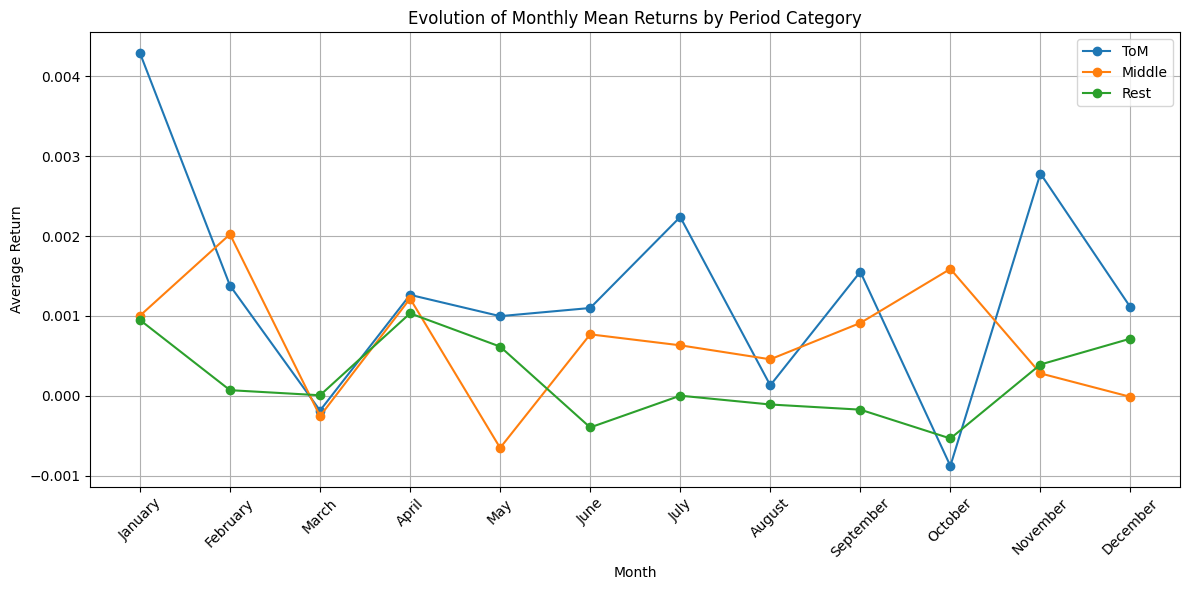

In [7]:
monthly_table = ToM_Middle_month_effect_new.average_return_per_month(df_with_periods)

Here, we compute the effects for each month.
In our graph, we see that returns during the turn-of-the-month period tend to remain consistently higher than returns in the other periods for most months.

For the half-month period, the pattern is less distinct: its average return is harder to differentiate from that of the remaining days. Nonetheless, it does appear to stay slightly higher than the rest of the days from June to October.

The remaining question is whether these higher averages reflect a genuine effect or whether they are statistically insignificant.

In [8]:
results = ToM_Middle_month_effect_new.month_effect_stat_test(df_with_periods)


================ Regression Results ================

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.923
Date:                Sun, 21 Dec 2025   Prob (F-statistic):            0.00269
Time:                        20:12:13   Log-Likelihood:             4.7324e+07
No. Observations:            24135301   AIC:                        -9.465e+07
Df Residuals:                24135298   BIC:                        -9.465e+07
Df Model:                           2                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

After running the following linear regression:
$$
\text{return} = c \;+\; \beta_{\text{ToM}} \cdot \mathbf{1}_{\text{ToM}} \;+\;
\beta_{\text{Half}} \cdot \mathbf{1}_{\text{Half}}
$$

we obtain the estimated coefficients, which capture how each period affects returns.

We also obtain the corresponding p-values, which indicate whether these effects are statistically significant.

Our results show that the turn-of-the-month effect is statistically significant, with a p-value of 0.000631.
In contrast, the half-month effect is not statistically significant, with a p-value of 0.224460.

Therefore, we conclude that the turn-of-the-month effect is significant, whereas the half-month effect is not.
In the next part of our analysis, we will focus exclusively on the turn-of-the-month effect.

ADDING a Log Volume column

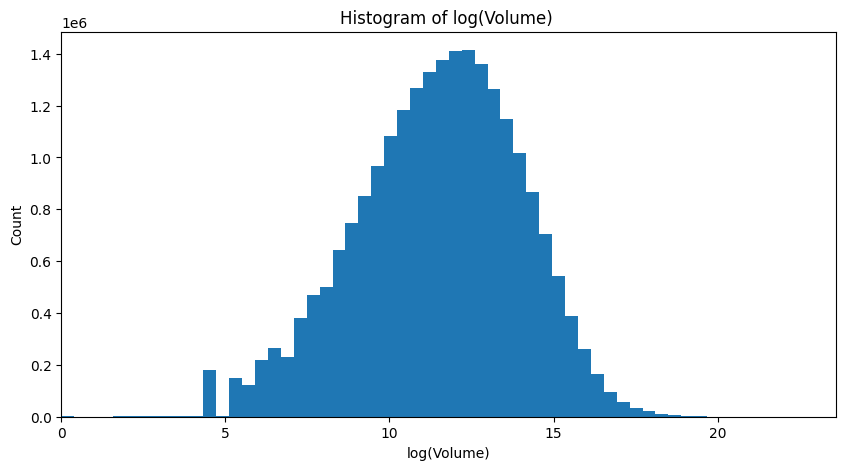

In [9]:
import numpy as np
import matplotlib.pyplot as plt


df_with_periods = df_with_periods[df_with_periods["Volume"] > 0]


df_with_periods["log_volume"] = np.log(df_with_periods["Volume"])


log_vol = df_with_periods["log_volume"]

vmin = log_vol.min()
vmax = log_vol.max()

plt.figure(figsize=(10, 5))
plt.hist(log_vol, bins=60)
plt.xlim(vmin, vmax)     
plt.xlabel("log(Volume)")
plt.ylabel("Count")
plt.title("Histogram of log(Volume) ")
plt.show()


In this part of the analysis, we extend the regression by including additional variables such as the federal funds rate and trading volume.

Because raw trading volume takes very large values and exhibits a heavily skewed, long-tailed distribution, we use the logarithm of volume instead. As shown in the plot above, the log-transformed volume is much closer to a normal distribution, making it more suitable for regression analysis.

In [10]:
ToM_Middle_month_effect_new.Month_effect_role_of_volume(df_with_periods)


 TOTAL EFFECT ( Return = f(Period) ) 
                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     9.666
Date:                Sun, 21 Dec 2025   Prob (F-statistic):            0.00189
Time:                        20:13:58   Log-Likelihood:             4.4629e+07
No. Observations:            22754331   AIC:                        -8.926e+07
Df Residuals:                22754329   BIC:                        -8.926e+07
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        

{'beta_total': np.float64(0.0009763497541232438),
 'beta_direct': np.float64(0.0009716753481231575),
 'beta_indirect': np.float64(4.674406000086282e-06)}

We perform two regressions:

1. A baseline model including only the turn-of-the-month indicator:

$$
\text{return} = c \;+\; \beta_{\text{ToM}} \cdot \mathbf{1}_{\text{ToM}}
$$

2. An extended model that also includes the log of trading volume:

$$
\text{return} = c \;+\; \beta_{\text{ToM}}^{\text{direct}} \cdot \mathbf{1}_{\text{ToM}}
\;+\; \gamma \cdot \log(\text{volume})
$$

The motivation for estimating both models is as follows.  
The turn-of-the-month period may influence trading volume, and trading volume may in turn affect returns.  
Thus, a higher average return during the turn-of-the-month could arise either because it is the turn-of-the-month, or because volume is systematically higher during this period.

The coefficient from the first regression, denoted *β_total, captures the *total effect of the turn-of-the-month on returns.  
The coefficient from the second regression, *β_direct, captures the *direct effect, since trading volume is now controlled for.

The *indirect effect*, representing the portion of the turn-of-the-month effect that operates through volume, is:

$$
\text{Indirect Effect} = \beta_{\text{total}} - \beta_{\text{direct}}
$$

Our results show an indirect effect of *0.000005*.  
Taking the ratio of the indirect effect to the total effect gives:

$$
\text{Ratio} = \frac{\text{Indirect Effect}}{\text{Total Effect}} \approx 0.0048
$$

This indicates that trading volume contributes only marginally to the elevated returns observed during the turn-of-the-month.  
In other words, the turn-of-the-month effect itself accounts for almost all of the increase in returns.

In [11]:
X_feat= ["is_ToM", "log_volume","FEDFUNDS"]

model,coef = ToM_Middle_month_effect_new.Month_effect_full_regression(df_with_periods, X_feat)
print(model.summary())
print(coef)

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     50.90
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           1.81e-32
Time:                        20:15:34   Log-Likelihood:             4.4632e+07
No. Observations:            22754331   AIC:                        -8.926e+07
Df Residuals:                22754327   BIC:                        -8.926e+07
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.000    -13.223      0.0

We now perform a full regression to evaluate the joint role of several parameters:  
the turn-of-the-month indicator, the log of trading volume, and the federal funds rate.  
The model is:

$$
\text{return} = c 
\;+\; \beta_{\text{ToM}} \cdot \mathbf{1}_{\text{ToM}}
\;+\; \gamma \cdot \log(\text{volume})
\;+\; \lambda \cdot \text{FEDFUNDS}
$$

The estimated coefficients are:

- $\beta_{\text{ToM}} = 0.001$  
- $\gamma = 0.0002$  
- $\lambda = 5.88 \times 10^{-5}$  

From these results, we observe that the turn-of-the-month coefficient contributes the most to explaining returns.  
The log of volume has a mild positive effect, while the federal funds rate appears to have essentially no influence on daily returns in our sample.

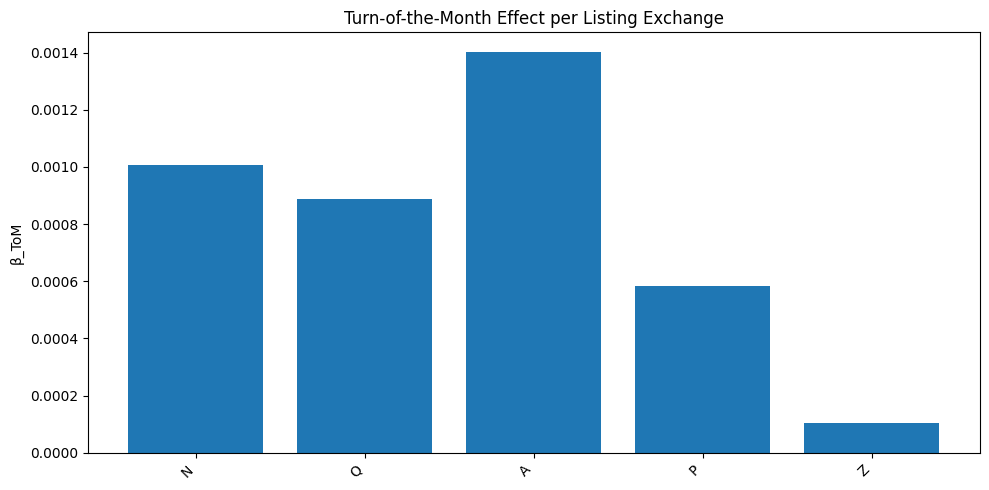

In [12]:
X_feat= ["is_ToM", "log_volume"]
beta_exch = ToM_Middle_month_effect_new.Month_effect_per_ListExchange(df_with_periods, X_feat)

Now we restrict our regression to only two variables: the turn-of-the-month indicator and the log of trading volume.  
Our goal is to examine whether the *stock exchange* on which a company is listed influences its return during the turn-of-the-month period.

After running a separate regression for each exchange type, we observe the following:

- *NYSE American (A)* shows the highest turn-of-the-month return, with a beta coefficient close to *0.14*.  
- *NASDAQ Global Market (Q)* and *NYSE (N)* display coefficients similar to our earlier overall estimate, indicating a comparable turn-of-the-month effect.  
- *NYSE Arca (P)* and *BATS (Z)* exhibit the lowest turn-of-the-month returns, with BATS showing nearly no effect at all.

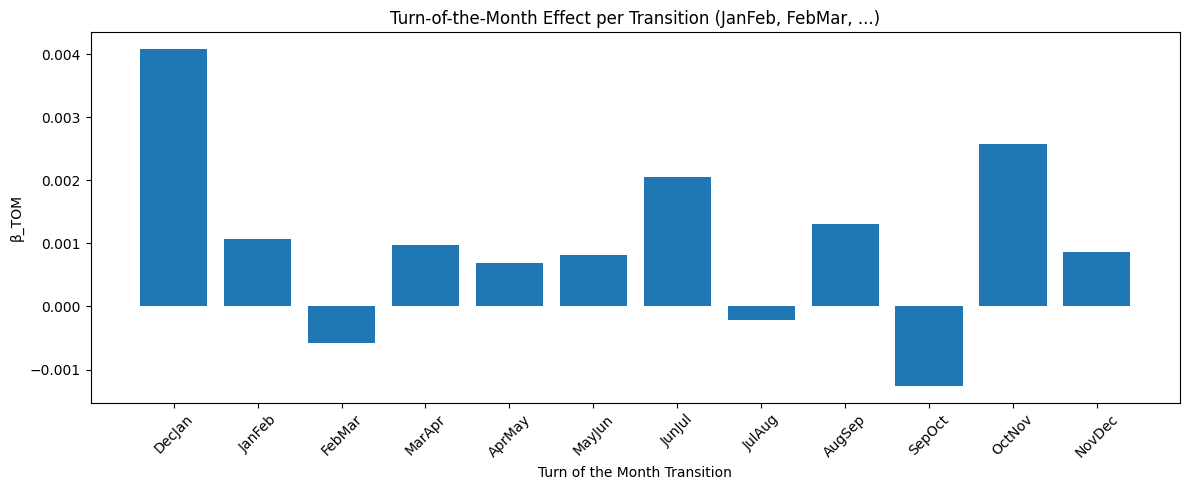

In [13]:
betas = ToM_Middle_month_effect_new.Month_effect_per_TurnedMonth(
    df_with_periods,
    X_feat)

We now run a regression for all 12 turn-of-the-month periods to identify whether certain month transitions exhibit stronger effects than others.

The results show that the turn-of-the-month effect is not homogeneous throughout the year.  
The *December → January* transition displays the highest return, which may be linked to holiday-related effects such as the Christmas and New Year period.

The next strongest effects occur during the *June → July* and *October → November* transitions.  
Most other month transitions exhibit only small positive returns, and in some cases even slightly negative returns.

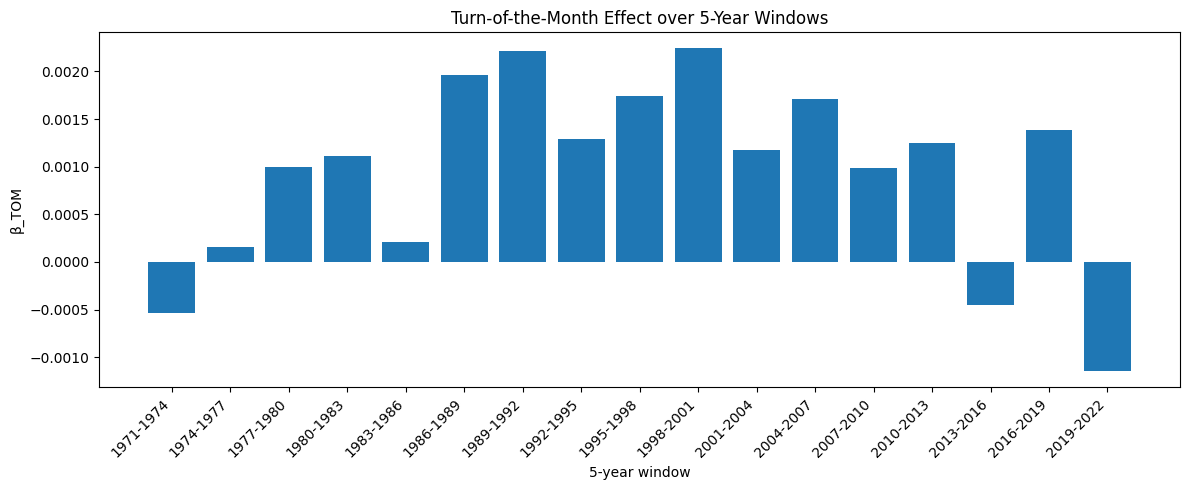

In [15]:
beta_year = ToM_Middle_month_effect_new.Month_effect_per_year_window(df_with_periods, X_feat,3)

Finally, we compute regressions to measure how the turn-of-the-month effect evolves over time.  
For this, we estimate the turn-of-the-month coefficient using rolling 3-year windows.

The results show that the effect is not homogeneous across years.  
In the late 1980s, the turn-of-the-month coefficient becomes relatively high (almost 0.002), which may coincide with the period during which this anomaly first began to be discussed in academic literature.

Across many periods, especially from the late 1980s to the early 2010s, the effect remains strong.  
However, several windows exhibit much weaker effects, and in some cases even negative coefficients.

Overall, most years display a noticeable turn-of-the-month effect, but there are periods where this effect appears to weaken significantly or even disappear entirely.